In [1]:
'''
Import necessary packages
'''
import numpy as np
import scipy
import scipy.integrate
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import pickle
from tqdm import tqdm

# from ip3_ca_ode import *
from ip3_ca_ode_cfg import *
import cfg

save = 'figures/ip3_ca_experiments/'

#set figure font sizes for readability
font = {'size' : 30,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Looking closer at spritz experiments (Summary)

This file is attempting to look at the spritz experiments to determine what causes their seemingly complex behavior. 

**The primary phenomena we're interested in looking at are:**

1. There is one transient stage where calcium spikes are produced at decreasing amplitudes
    1. In the case of glutamate pulses at 100$\mu$M, this first transient stage takes a long time. This actually reminds me of the delays we saw before oscillations began when doing bath stimulation protocols in that it seems like c$_{ER}$ has to be low enough for this to initiate, but actually dips below the region of "interesting behavior" before slowly returning to it. So it looks like this phenomenon might also require multiple variables to be in the correct regimes and they cause overshoots for each other?
    2. The first transient behavior seems to be driven initially by c$_{ER}$ depletion, where cytosolic calcium spikes are not as large since there is less calcium available from ER storage.
    3. Turning Gd1 off causes calcium spikes to be larger since G* repsonds more strongly, which causes c$_{ER}$ to deplete more quickly. 
    
2. A second stage occurs where the calcium responds only to every other spikes (i.e., not every stimulation produces a response)
    1. In looking at the color plot showing how glutamate spritz strength and c$_{ER}$ level affect calcium spike amplitude, there seems to be a slightly critical region between no spike occuring at all and some spike (amplitude around 0.4-0.6). This is likely the cause of missing every other spike, where the missed spike gives time for c$_{ER}$ levels to recover

Looking at the ER calcium levels, it seems the depletion is mainly responsible for the absent spikes. As stimulation continues (after 10+ spikes) spikes become smaller due to slow desentization of the GPCR. 

It seems that whether a spike occurs or not is primarily a function of the ER calcium levels (and likely also the G* level, but this is largely constant at each stimulation). When a spritz occurs, if there is enough calcium in the ER, the calcium increases beyond a certain threshold limit which triggers the spike (as can be seen in the IP3 production trace, which has a secondary increase when a spike occurs. Thus the actual spike seems to be driven by Ca2+ -> IP3 positive feedback when it breaches the critical threshold).

## Data Collection

The code here runs a spritz experiment and saves it to the experiments folder

In [17]:
'''Running a normal spritz experiment'''

cfg.t_f = 2000
cfg.input_duration = 2000


# fig, ax = plt.subplots(4, 2, figsize=(20, 10), sharey='row')

cfg.input_max = 50
cfg.oscillation_on_duration = 0.06
cfg.oscillation_off_duration = 30
cfg.num_oscillations = 50

set_gpcr_params(1)

run_experiment('oscillation', t_f=cfg.t_f, max_step=0.005)
save_experiment('50_0.06_30_50')

Experiment saved


In [ ]:
'''Running a spritz experiment while turning Gd1 or Gd2 off'''

cfg.t_f = 2000
cfg.input_duration = 2000


# fig, ax = plt.subplots(4, 2, figsize=(20, 10), sharey='row')

cfg.input_max = 50
cfg.oscillation_on_duration = 0.06
cfg.oscillation_off_duration = 30
cfg.num_oscillations = 50

set_gpcr_params(1)

# cfg.kd1 = 0
# cfg.kd2 = 0
# cfg.v_delta = 0
# cfg.v_3k = 0
cfg.k_d = 1.1

run_experiment('oscillation', t_f=cfg.t_f, max_step=0.005)
save_experiment('50_0.06_30_50_Neg_down_1.1')

# cfg.kd1 = 0.02
# cfg.kd2 = 0.6
# cfg.v_delta = 0.01
# cfg.v_3k = 0.1
cfg.k_d = 0.7

In [2]:
'''Running a spritz experiment with a noisy input to see how strongly this affects calcium spikes'''

cfg.t_f = 1000
cfg.input_duration = 1000


# fig, ax = plt.subplots(4, 2, figsize=(20, 10), sharey='row')

cfg.input_max = 50
cfg.oscillation_on_duration = 0.06
cfg.oscillation_off_duration = 30
cfg.num_oscillations = 50

set_gpcr_params(1)

cfg.oscillation_noise_scale = 0.05

run_experiment('noisy_oscillation', t_f=cfg.t_f, max_step=0.005)
save_experiment('50_0.06_30_25_noisy')

cfg.oscillation_noise_scale = 0.05

Experiment saved


# Initial Plots

Here we simply plot some numerical simulation plots

## Fluxes

We include the fluxes here and show spritz experiments for both param set 1 and 2 (they look pretty similar, so for the remainder of this file we simply stick with param set 1)

Experiment loaded


Text(0.5, 1.0, 'Param Set 1')

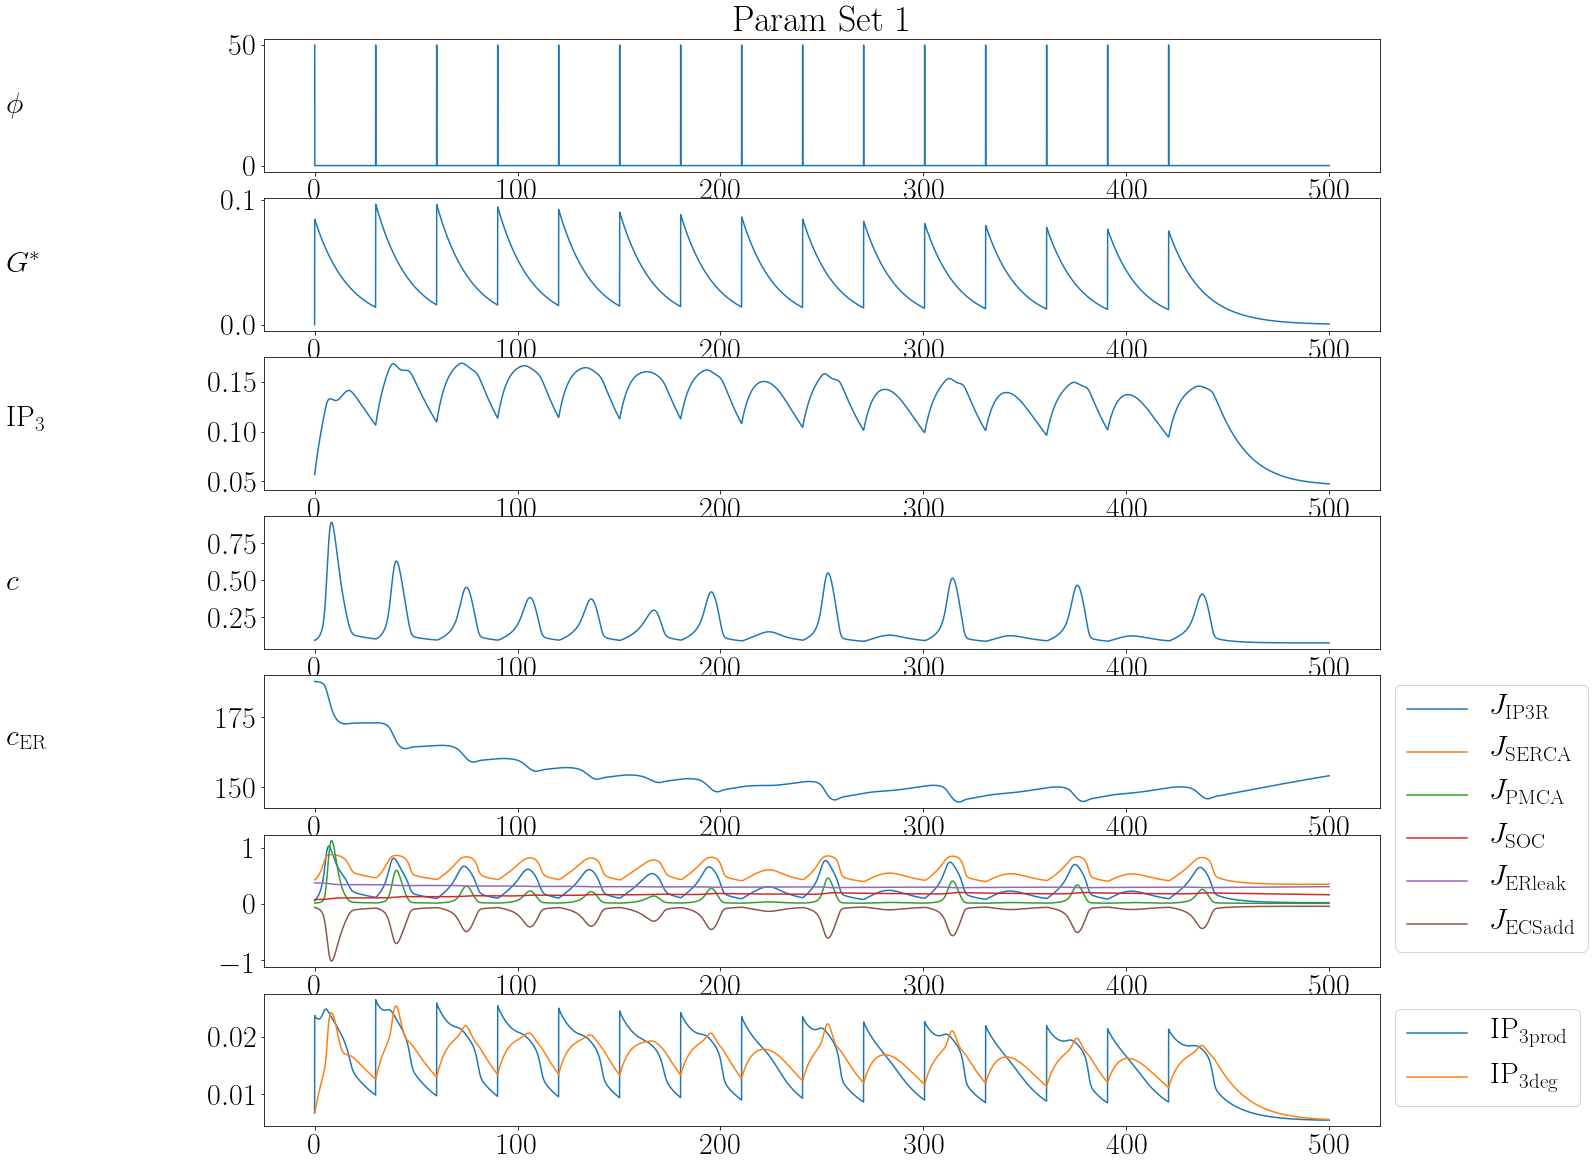

In [45]:
load_experiment('0.06_30_spritz_param_1')
labels = ['glut', 'Gstar', 'p', 'c', 'c_er']
flux_labels = {
    'J_ip3r': r'$J_\mathrm{IP3R}$',
    'J_serca': r'$J_\mathrm{SERCA}$',
    'J_pmca': r'$J_\mathrm{PMCA}$',
    'J_soc': r'$J_\mathrm{SOC}$',
    'J_er_leak': r'$J_\mathrm{ER leak}$',
    'J_ecs_add': r'$J_\mathrm{ECS add}$',
}
ip3_labels = {
    'ip3_production': r'IP$_{3\mathrm{prod}}$',
    'ip3_degradation': r'IP$_{3\mathrm{deg}}$'
}

fig, ax = plt.subplots(len(labels)+2, 1, figsize=(20, 20))
plot_experiment_plots(labels, axs=ax)
for i, label in enumerate(flux_labels.keys()):
    color = color_cycle[i]
    ax[len(labels)].plot(cfg.t, getattr(cfg, label), c=color, label=flux_labels[label])

for i, label in enumerate(ip3_labels.keys()):
    color = color_cycle[i]
    ax[len(labels) + 1].plot(cfg.t, getattr(cfg, label), c=color, label=ip3_labels[label])
    
ax[len(labels)].legend(loc='lower left', bbox_to_anchor=(1, 0))
ax[len(labels) + 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

ax[0].set_title('Param Set 1')

Experiment loaded


Text(0.5, 1.0, 'Param Set 2')

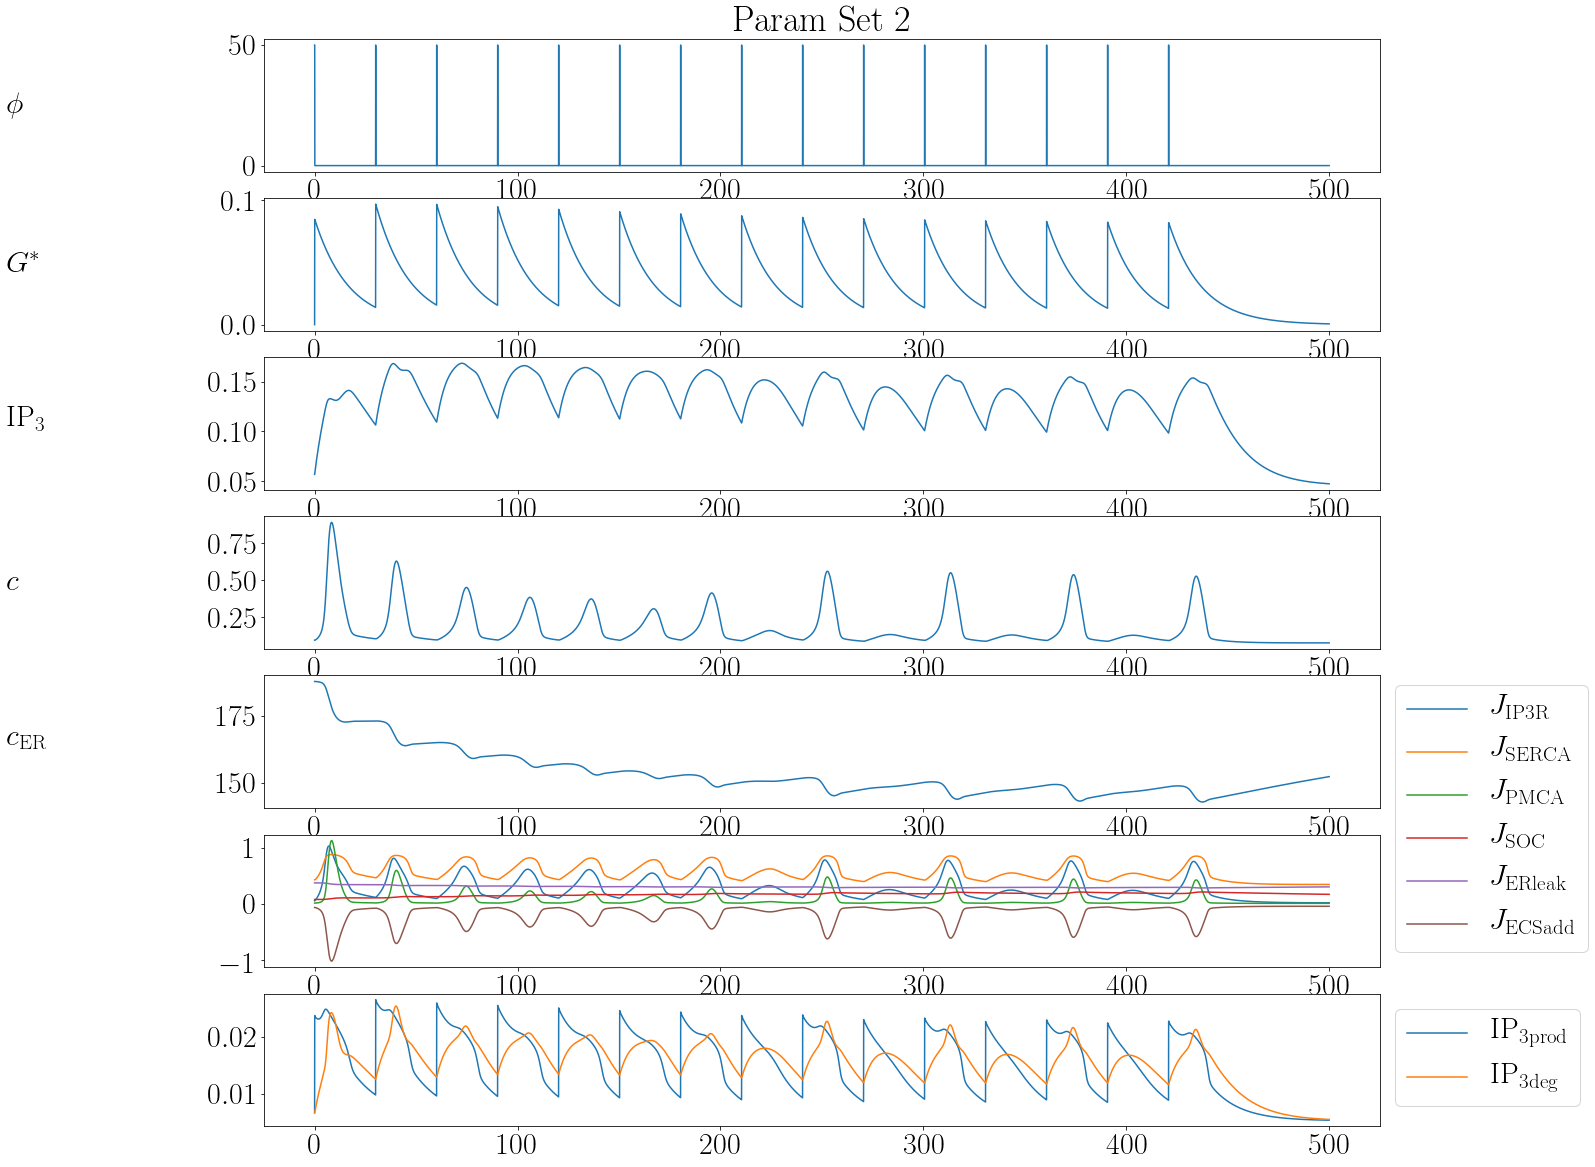

In [46]:
load_experiment('0.06_30_spritz_param_2')
labels = ['glut', 'Gstar', 'p', 'c', 'c_er']
flux_labels = {
    'J_ip3r': r'$J_\mathrm{IP3R}$',
    'J_serca': r'$J_\mathrm{SERCA}$',
    'J_pmca': r'$J_\mathrm{PMCA}$',
    'J_soc': r'$J_\mathrm{SOC}$',
    'J_er_leak': r'$J_\mathrm{ER leak}$',
    'J_ecs_add': r'$J_\mathrm{ECS add}$',
}
ip3_labels = {
    'ip3_production': r'IP$_{3\mathrm{prod}}$',
    'ip3_degradation': r'IP$_{3\mathrm{deg}}$'
}

fig, ax = plt.subplots(len(labels)+2, 1, figsize=(20, 20))
plot_experiment_plots(labels, axs=ax)
for i, label in enumerate(flux_labels.keys()):
    color = color_cycle[i]
    ax[len(labels)].plot(cfg.t, getattr(cfg, label), c=color, label=flux_labels[label])

for i, label in enumerate(ip3_labels.keys()):
    color = color_cycle[i]
    ax[len(labels) + 1].plot(cfg.t, getattr(cfg, label), c=color, label=ip3_labels[label])
    
ax[len(labels)].legend(loc='lower left', bbox_to_anchor=(1, 0))
ax[len(labels) + 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

ax[0].set_title('Param Set 2')

## More Spritzes

Here we have some plots showing the same experiment but with more spritz to look for more transient behavior

Experiment loaded


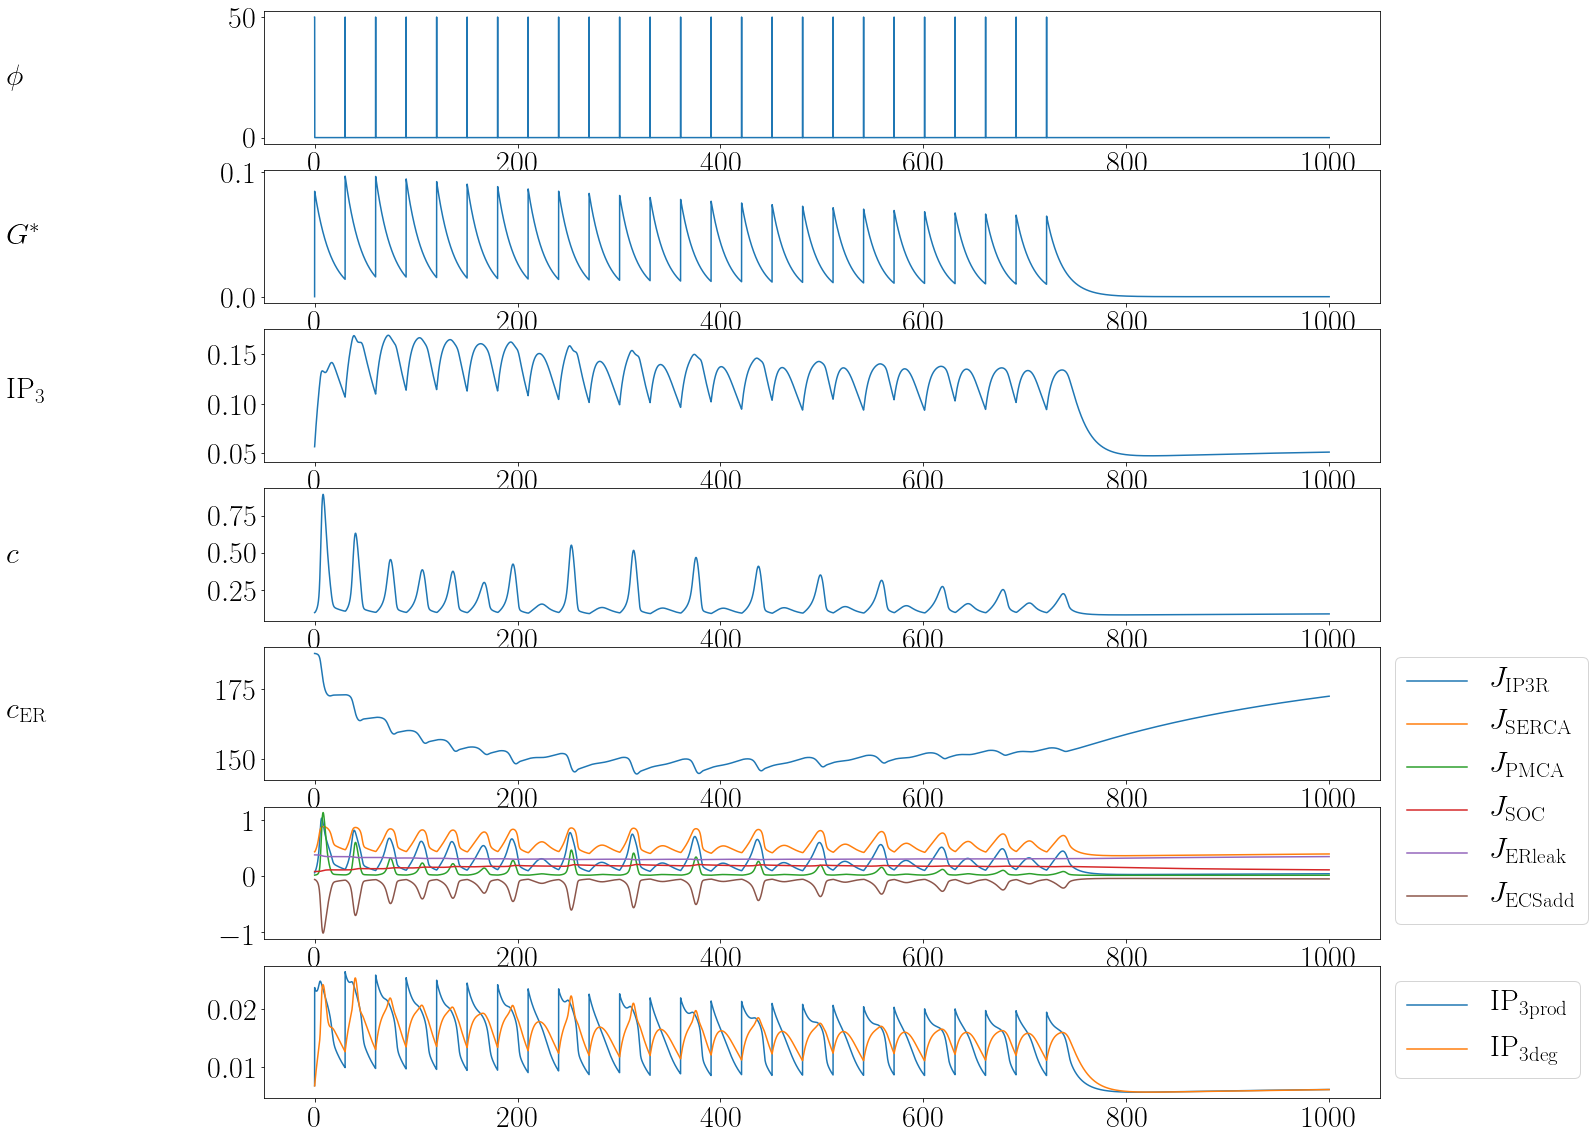

In [17]:
load_experiment('0.06_30_25spritz_param_1')
labels = ['glut', 'Gstar', 'p', 'c', 'c_er']
flux_labels = {
    'J_ip3r': r'$J_\mathrm{IP3R}$',
    'J_serca': r'$J_\mathrm{SERCA}$',
    'J_pmca': r'$J_\mathrm{PMCA}$',
    'J_soc': r'$J_\mathrm{SOC}$',
    'J_er_leak': r'$J_\mathrm{ER leak}$',
    'J_ecs_add': r'$J_\mathrm{ECS add}$',
}
ip3_labels = {
    'ip3_production': r'IP$_{3\mathrm{prod}}$',
    'ip3_degradation': r'IP$_{3\mathrm{deg}}$'
}

fig, ax = plt.subplots(len(labels)+2, 1, figsize=(20, 20))
plot_experiment_plots(labels, axs=ax)
for i, label in enumerate(flux_labels.keys()):
    color = color_cycle[i]
    ax[len(labels)].plot(cfg.t, getattr(cfg, label), c=color, label=flux_labels[label])

for i, label in enumerate(ip3_labels.keys()):
    color = color_cycle[i]
    ax[len(labels) + 1].plot(cfg.t, getattr(cfg, label), c=color, label=ip3_labels[label])
    
ax[len(labels)].legend(loc='lower left', bbox_to_anchor=(1, 0))
ax[len(labels) + 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

Experiment loaded


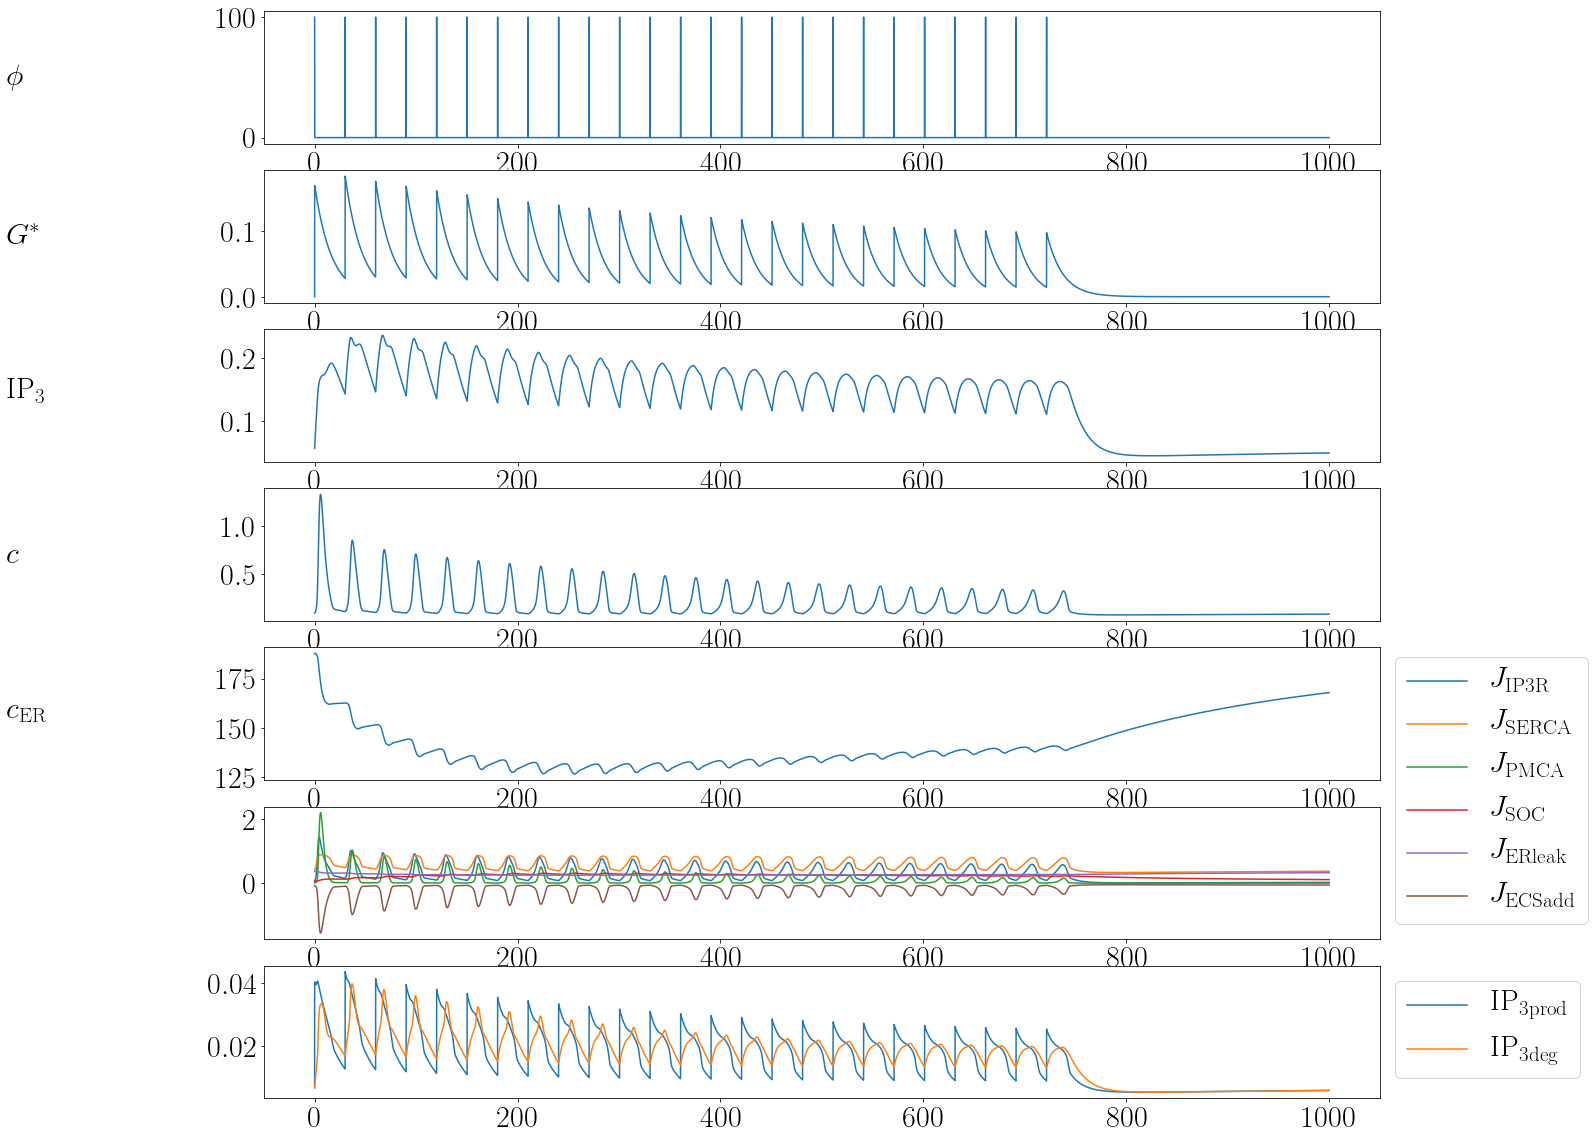

In [19]:
load_experiment('100_0.06_30_25spritz_param_1')
labels = ['glut', 'Gstar', 'p', 'c', 'c_er']
flux_labels = {
    'J_ip3r': r'$J_\mathrm{IP3R}$',
    'J_serca': r'$J_\mathrm{SERCA}$',
    'J_pmca': r'$J_\mathrm{PMCA}$',
    'J_soc': r'$J_\mathrm{SOC}$',
    'J_er_leak': r'$J_\mathrm{ER leak}$',
    'J_ecs_add': r'$J_\mathrm{ECS add}$',
}
ip3_labels = {
    'ip3_production': r'IP$_{3\mathrm{prod}}$',
    'ip3_degradation': r'IP$_{3\mathrm{deg}}$'
}

fig, ax = plt.subplots(len(labels)+2, 1, figsize=(20, 20))
plot_experiment_plots(labels, axs=ax)
for i, label in enumerate(flux_labels.keys()):
    color = color_cycle[i]
    ax[len(labels)].plot(cfg.t, getattr(cfg, label), c=color, label=flux_labels[label])

for i, label in enumerate(ip3_labels.keys()):
    color = color_cycle[i]
    ax[len(labels) + 1].plot(cfg.t, getattr(cfg, label), c=color, label=ip3_labels[label])
    
ax[len(labels)].legend(loc='lower left', bbox_to_anchor=(1, 0))
ax[len(labels) + 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

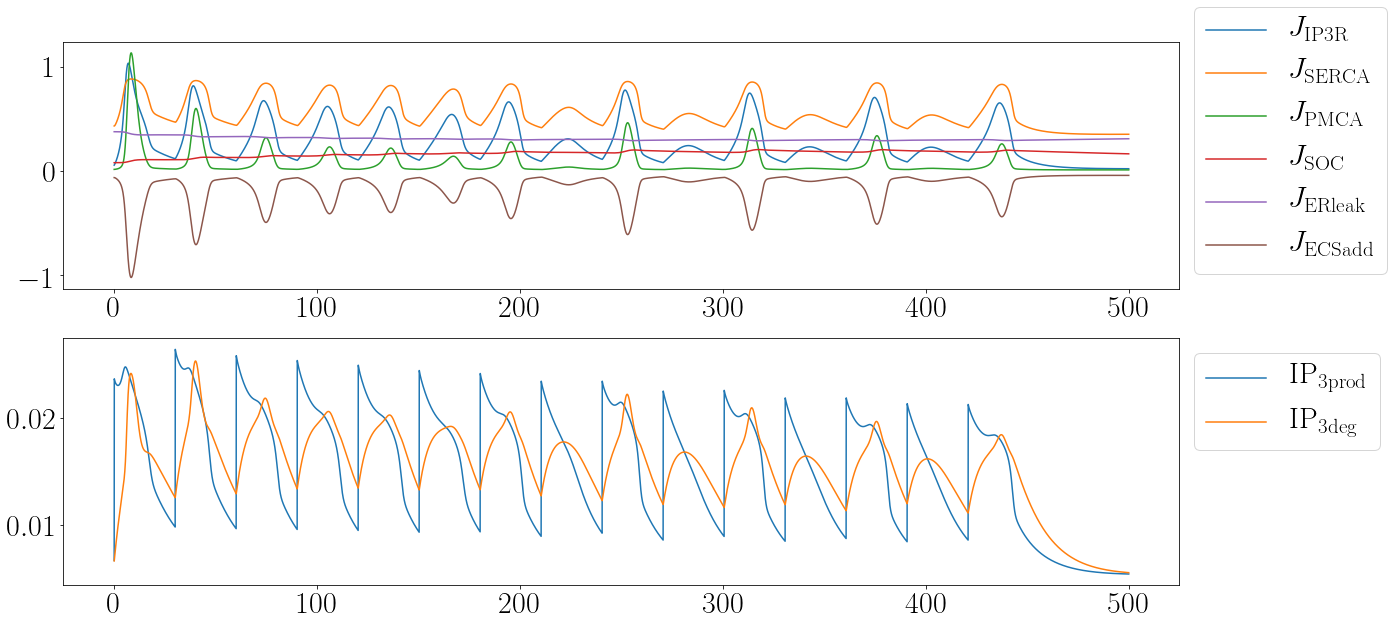

In [13]:
# Zoom to just the fluxes

flux_labels = {
    'J_ip3r': r'$J_\mathrm{IP3R}$',
    'J_serca': r'$J_\mathrm{SERCA}$',
    'J_pmca': r'$J_\mathrm{PMCA}$',
    'J_soc': r'$J_\mathrm{SOC}$',
    'J_er_leak': r'$J_\mathrm{ER leak}$',
    'J_ecs_add': r'$J_\mathrm{ECS add}$',
}
ip3_labels = {
    'ip3_production': r'IP$_{3\mathrm{prod}}$',
    'ip3_degradation': r'IP$_{3\mathrm{deg}}$'
}

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
for i, label in enumerate(flux_labels.keys()):
    color = color_cycle[i]
    ax[0].plot(cfg.t, getattr(cfg, label), c=color, label=flux_labels[label])

for i, label in enumerate(ip3_labels.keys()):
    color = color_cycle[i]
    ax[1].plot(cfg.t, getattr(cfg, label), c=color, label=ip3_labels[label])
    
ax[0].legend(loc='lower left', bbox_to_anchor=(1, 0))
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Testing with controlled ER calcium and spritz strengths

To explore how calcium peak depends on c$_{ER}$ and $G^*$, we manually set the c$_{ER}$ level and give a single spritz from rest of variable glutamate strength. This lets us mostly control the $G^*$ level (there are likely slight dynamics differences when Gd1 and Gd2 have had time to build up in the actual spritz experiments)

**This shows that there is a critical area of c$_{ER}$ and $G^*$ required to actually produce a calcium spike**

More complete data collection and plotting code in the ip3_ca_experiments.ipynb file

Text(0.5, 1.0, 'c peaks')

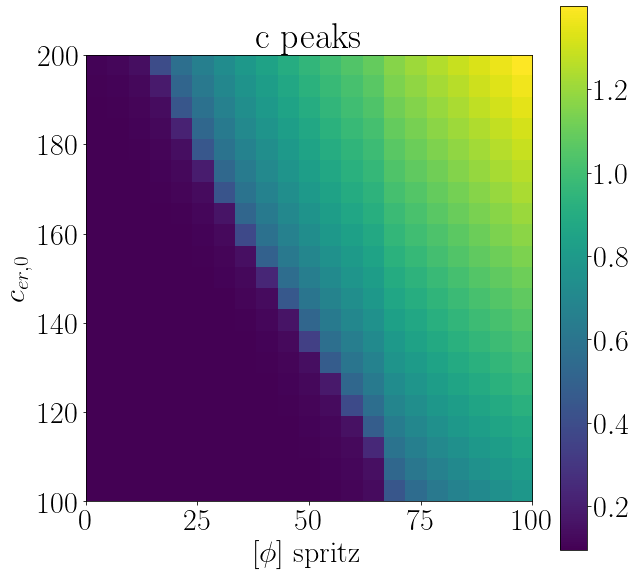

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(np.flip(np.array(c_peaks).reshape(21, 21), 0), extent=(0, 100, 100, 200))
plt.colorbar()
plt.ylabel('$c_{er,0}$')
plt.xlabel('[$\phi$] spritz')
plt.title('c peaks')

# Turning off Gd1, Gd2

To explore the effects of Gd1 and Gd2, we turn them off and perform the spritz experiments. Maybe unsurprisingly, Gd2 contributes to calcium responses becoming small in the long term. Gd1 has an interesting effect where it causes early desensitization, hence smaller calcium peaks early on, but since this also means c$_{ER}$ is depleted less. There is still a "desensitization" effect without Gd1 from c$_{ER}$ depletion, and the Gd1 off vs Control plots look similar after transients are completed (in the long run, Gd2 has the larger effect)

Experiment loaded
Experiment loaded
Experiment loaded


C:\Users\Andy\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


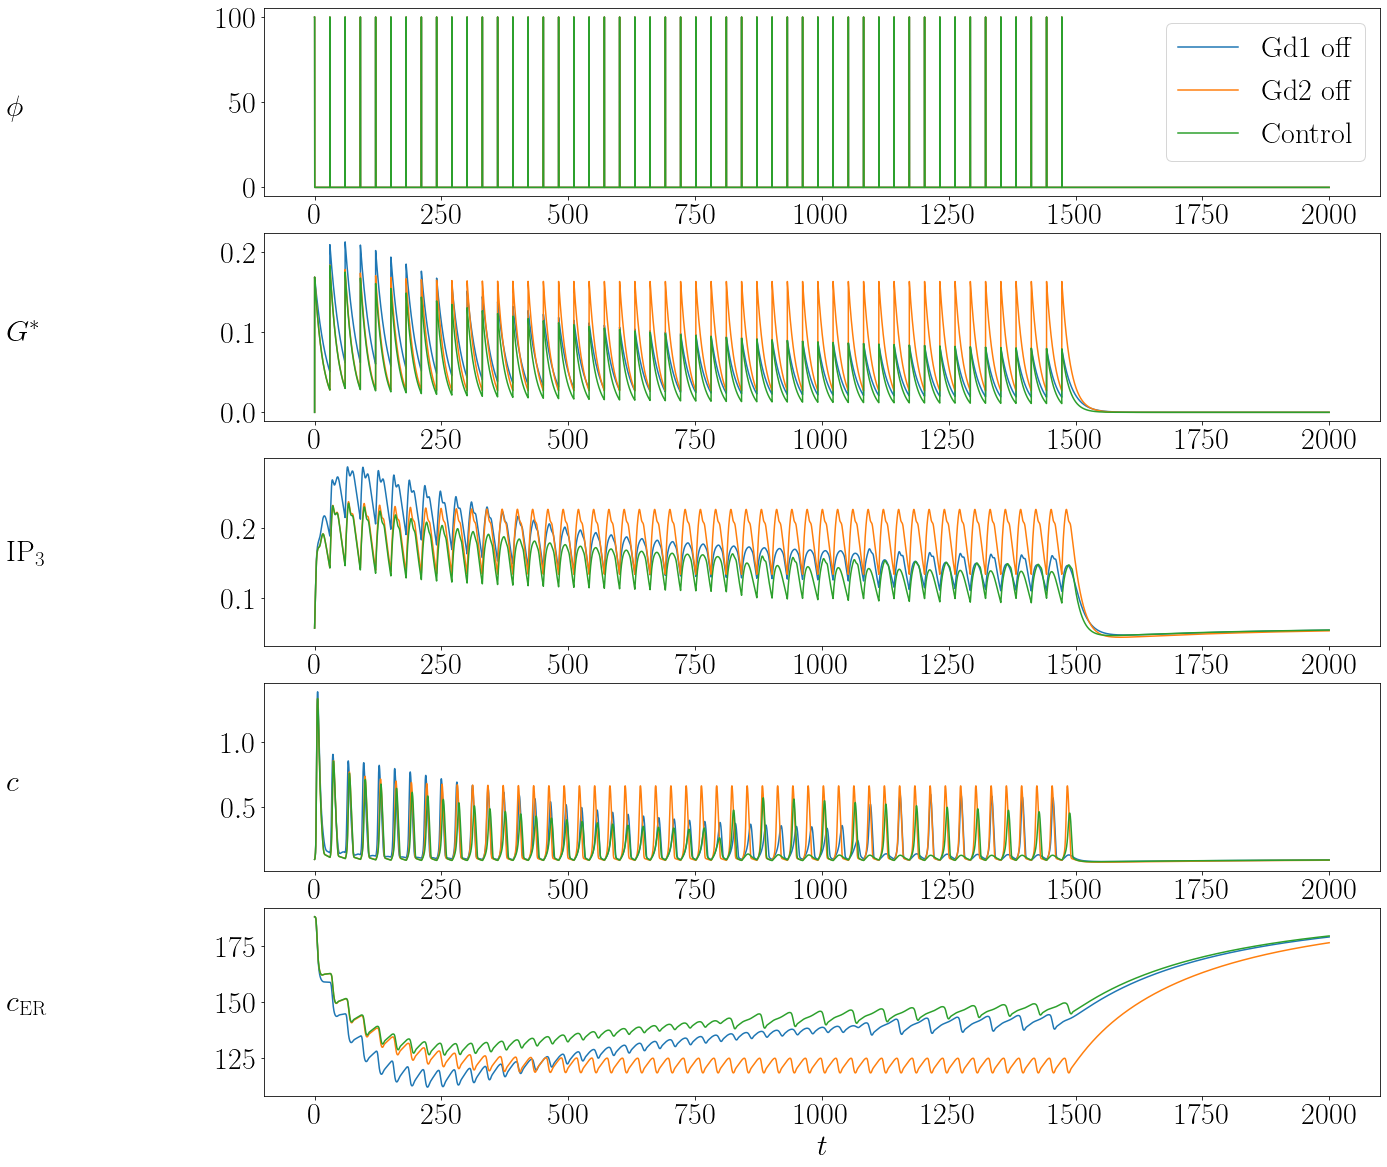

In [8]:
labels = ['glut', 'Gstar', 'p', 'c', 'c_er']
fig, ax = plt.subplots(5, 1, figsize=(20, 20))

load_experiment('100_0.06_30_50_Gd1_off')
plot_experiment_plots(labels, axs=ax, legend_label='Gd1 off')

load_experiment('100_0.06_30_50_Gd2_off')
plot_experiment_plots(labels, axs=ax, legend_label='Gd2 off')

load_experiment('100_0.06_30_50')
plot_experiment_plots(labels, axs=ax, legend_label='Control')


ax[0].legend()

Experiment loaded
Experiment loaded


C:\Users\Andy\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


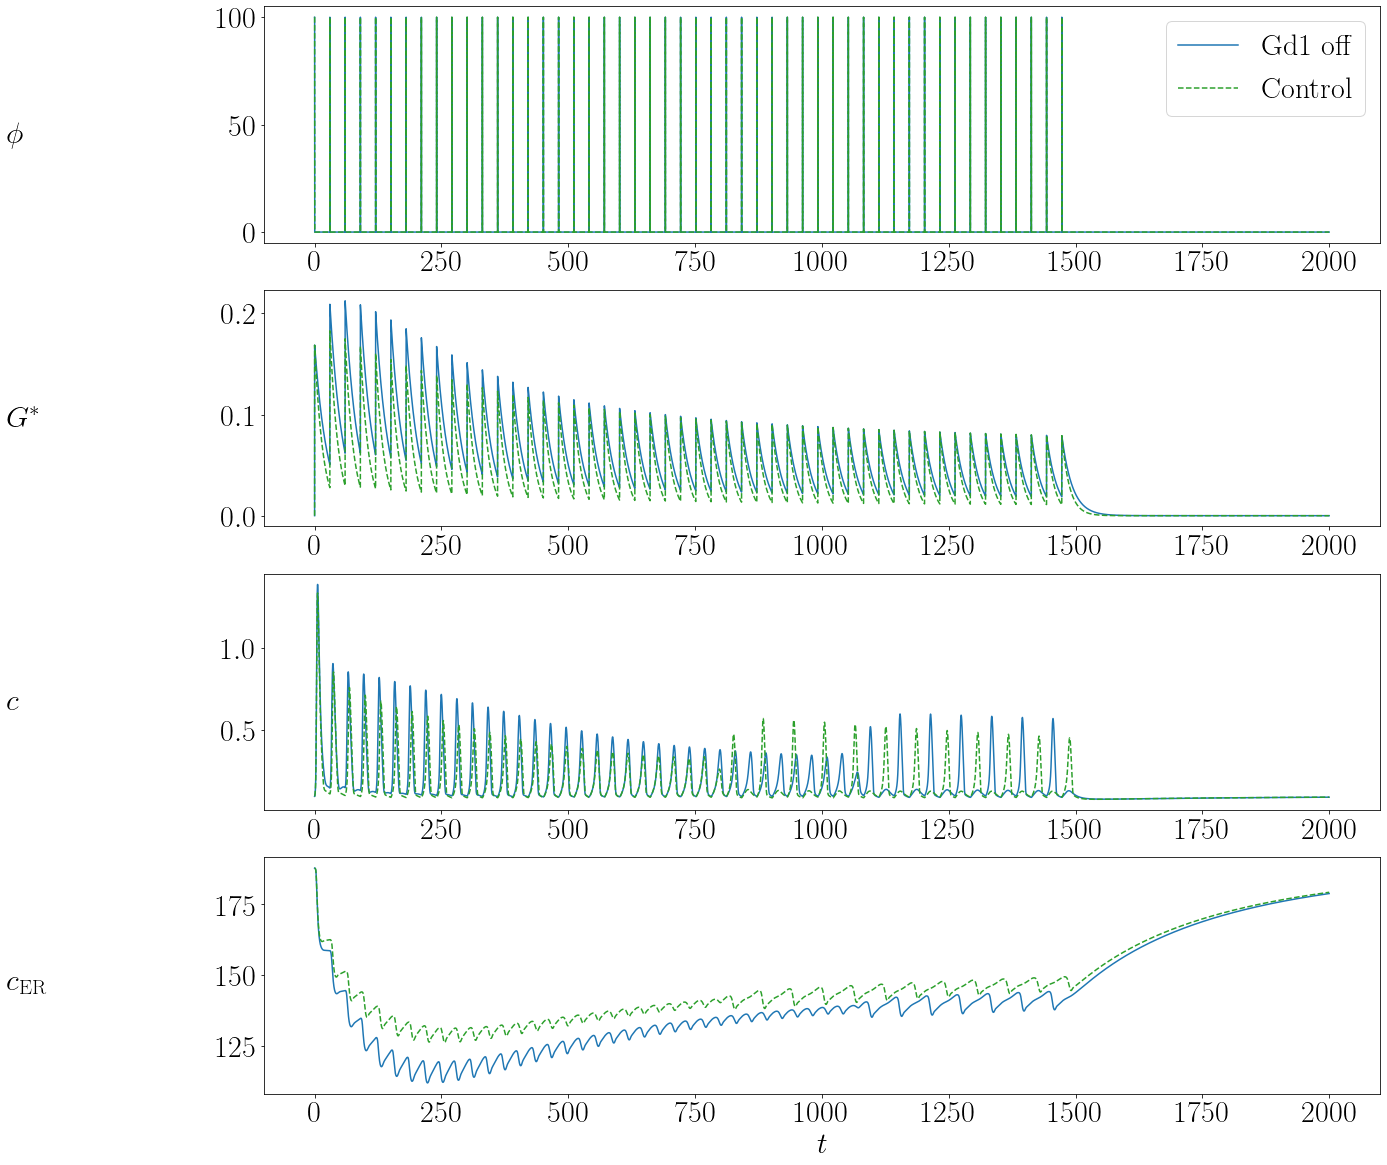

In [48]:
labels = ['glut', 'Gstar', 'c', 'c_er']
fig, ax = plt.subplots(4, 1, figsize=(20, 20))

load_experiment('100_0.06_30_50_Gd1_off')
plot_experiment_plots(labels, axs=ax, legend_label='Gd1 off', color=color_cycle[0])

# load_experiment('100_0.06_30_50_Gd2_off')
# plot_experiment_plots(labels, axs=ax, legend_label='Gd2 off')

load_experiment('100_0.06_30_50')
plot_experiment_plots(labels, axs=ax, legend_label='Control', color=color_cycle[2], linestyle='--')


ax[0].legend()

Experiment loaded
Experiment loaded
Experiment loaded


C:\Users\Andy\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


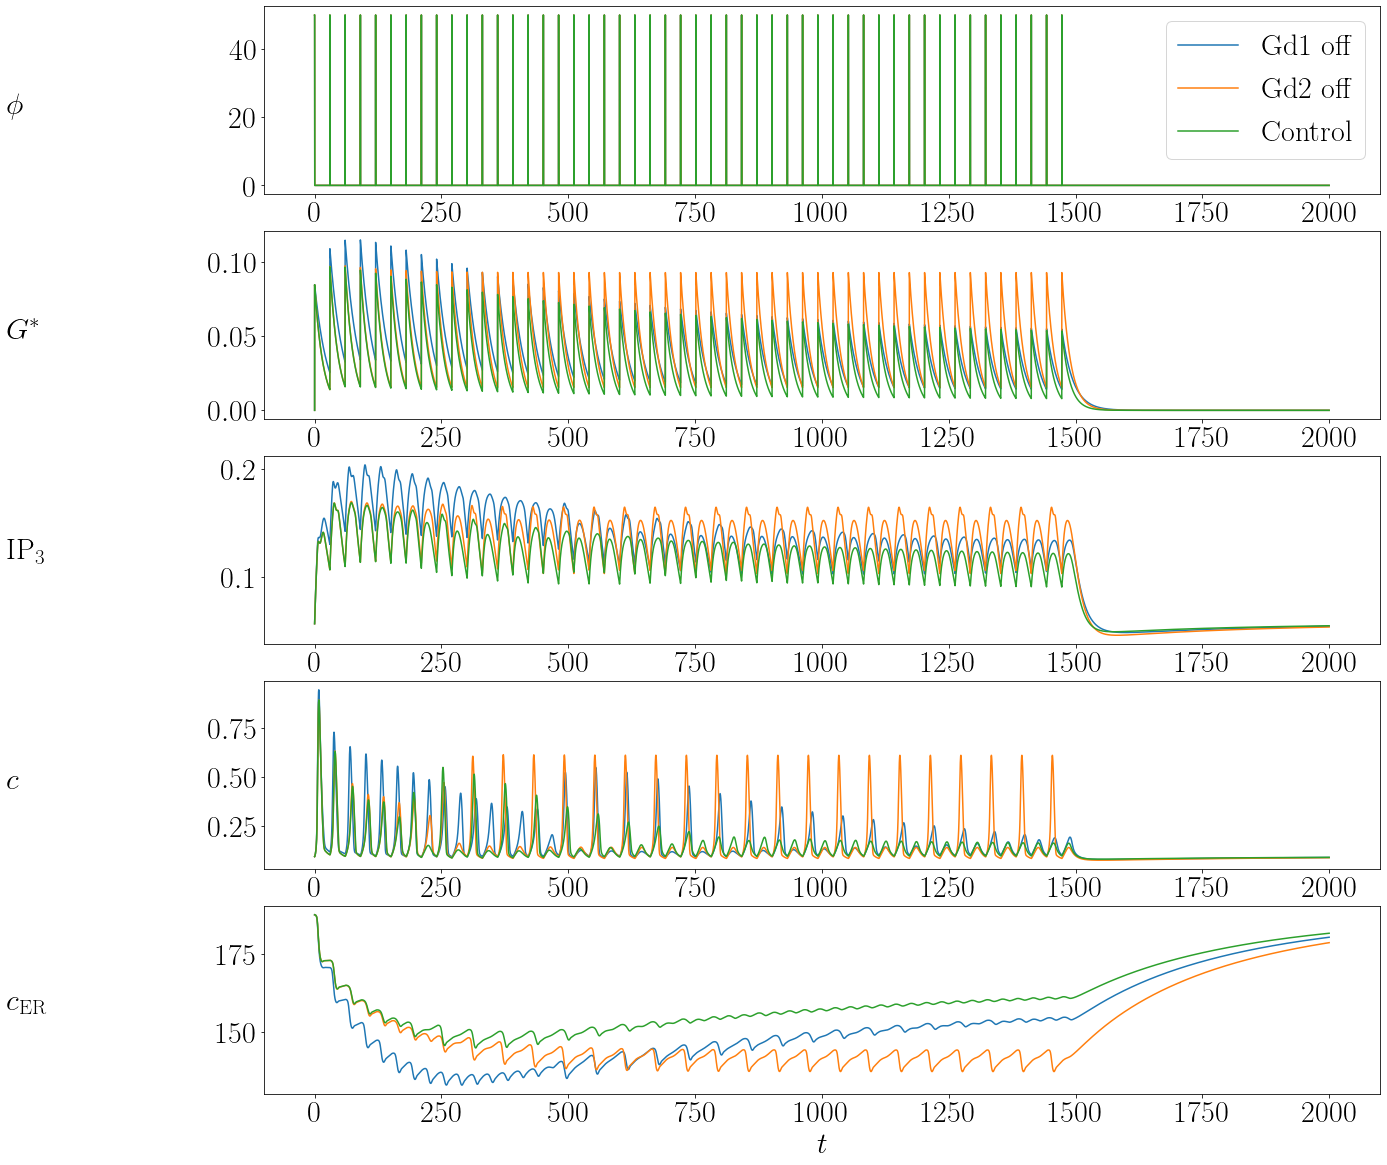

In [21]:
labels = ['glut', 'Gstar', 'p', 'c', 'c_er']
fig, ax = plt.subplots(5, 1, figsize=(20, 20))

load_experiment('50_0.06_30_50_Gd1_off')
plot_experiment_plots(labels, axs=ax, legend_label='Gd1 off')

load_experiment('50_0.06_30_50_Gd2_off')
plot_experiment_plots(labels, axs=ax, legend_label='Gd2 off')

load_experiment('50_0.06_30_50')
plot_experiment_plots(labels, axs=ax, legend_label='Control')


ax[0].legend()

# Turning off Pos/Neg Feedback


Experiment loaded
Experiment loaded
Experiment loaded


C:\Users\Andy\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


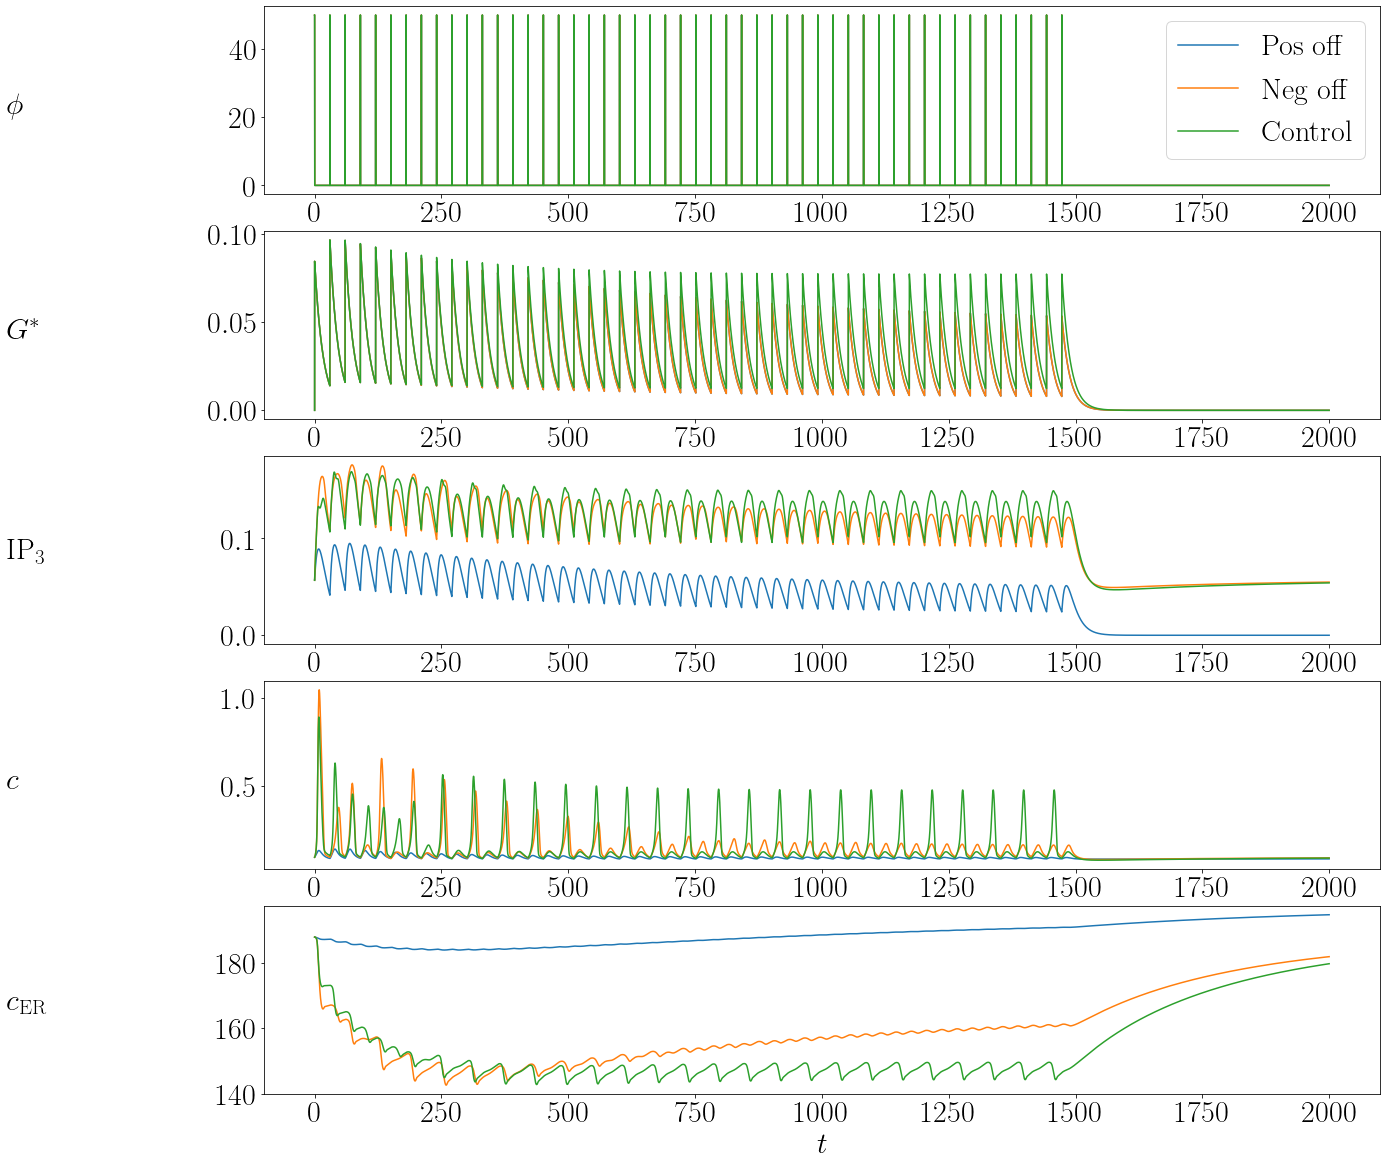

In [6]:
labels = ['glut', 'Gstar', 'p', 'c', 'c_er']
fig, ax = plt.subplots(5, 1, figsize=(20, 20))

load_experiment('50_0.06_30_50_Pos_off')
plot_experiment_plots(labels, axs=ax, legend_label='Pos off')

load_experiment('50_0.06_30_50_Neg_off')
plot_experiment_plots(labels, axs=ax, legend_label='Neg off')

load_experiment('50_0.06_30_50')
plot_experiment_plots(labels, axs=ax, legend_label='Control')


ax[0].legend()

Experiment loaded
Experiment loaded


C:\Users\Andy\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


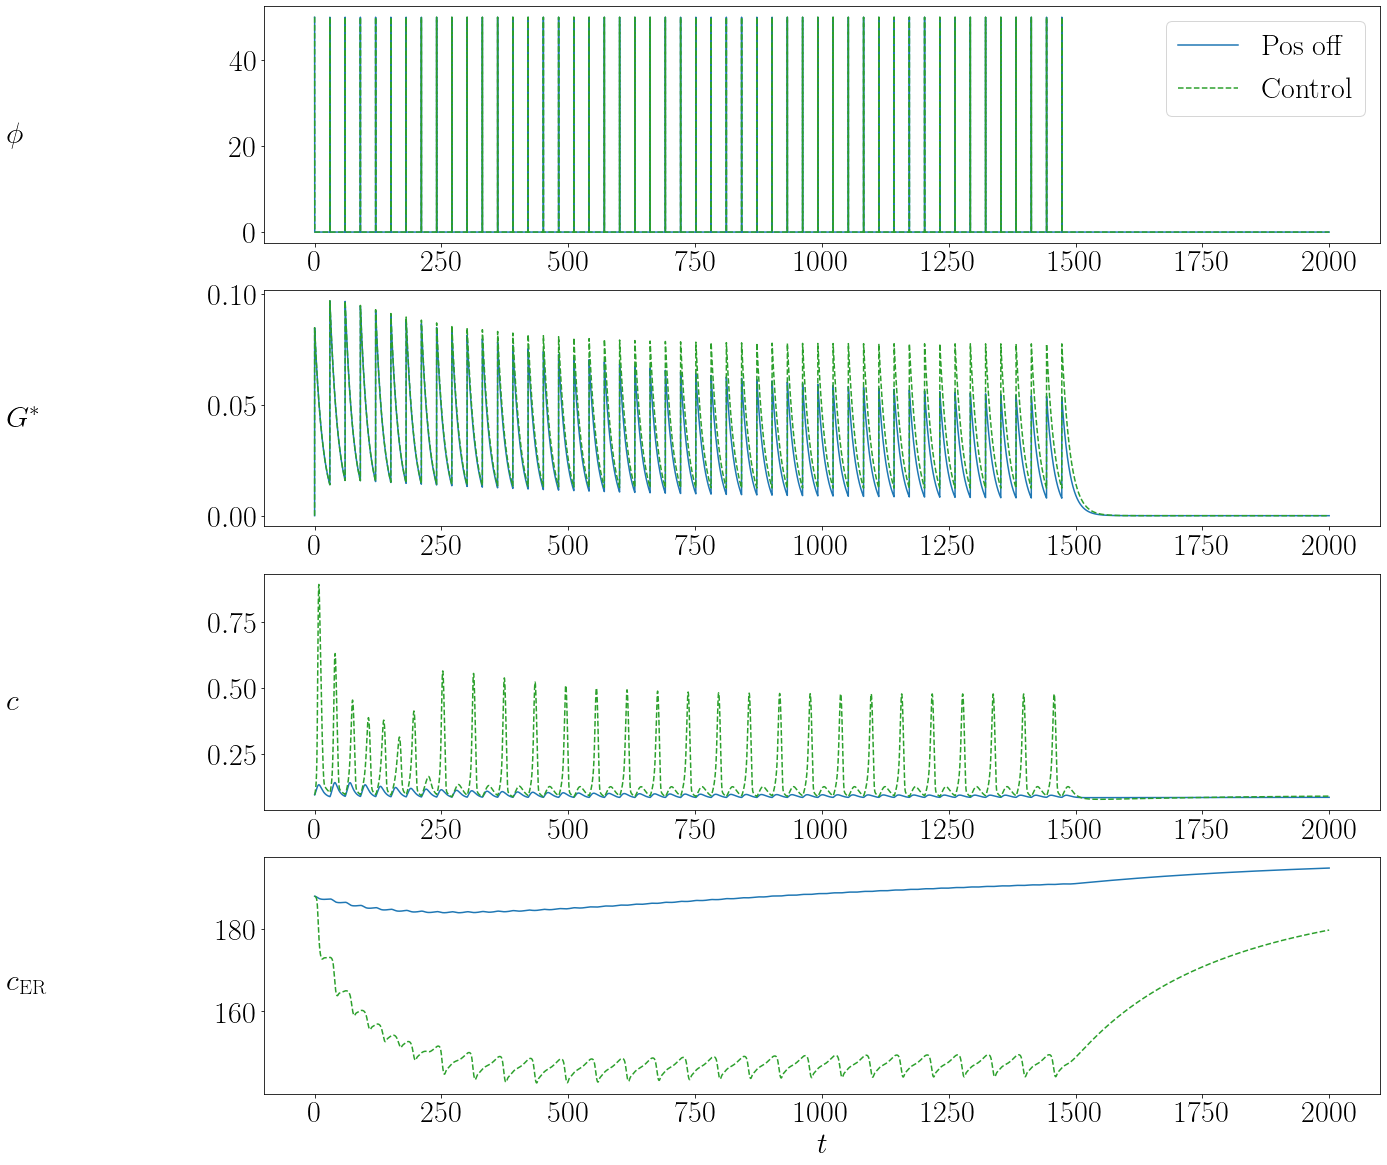

In [7]:
labels = ['glut', 'Gstar', 'c', 'c_er']
fig, ax = plt.subplots(4, 1, figsize=(20, 20))

load_experiment('50_0.06_30_50_Pos_off')
plot_experiment_plots(labels, axs=ax, legend_label='Pos off', color=color_cycle[0])

# load_experiment('100_0.06_30_50_Gd2_off')
# plot_experiment_plots(labels, axs=ax, legend_label='Gd2 off')

load_experiment('50_0.06_30_50')
plot_experiment_plots(labels, axs=ax, legend_label='Control', color=color_cycle[2], linestyle='--')


ax[0].legend()

Experiment loaded
Experiment loaded


C:\Users\Andy\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


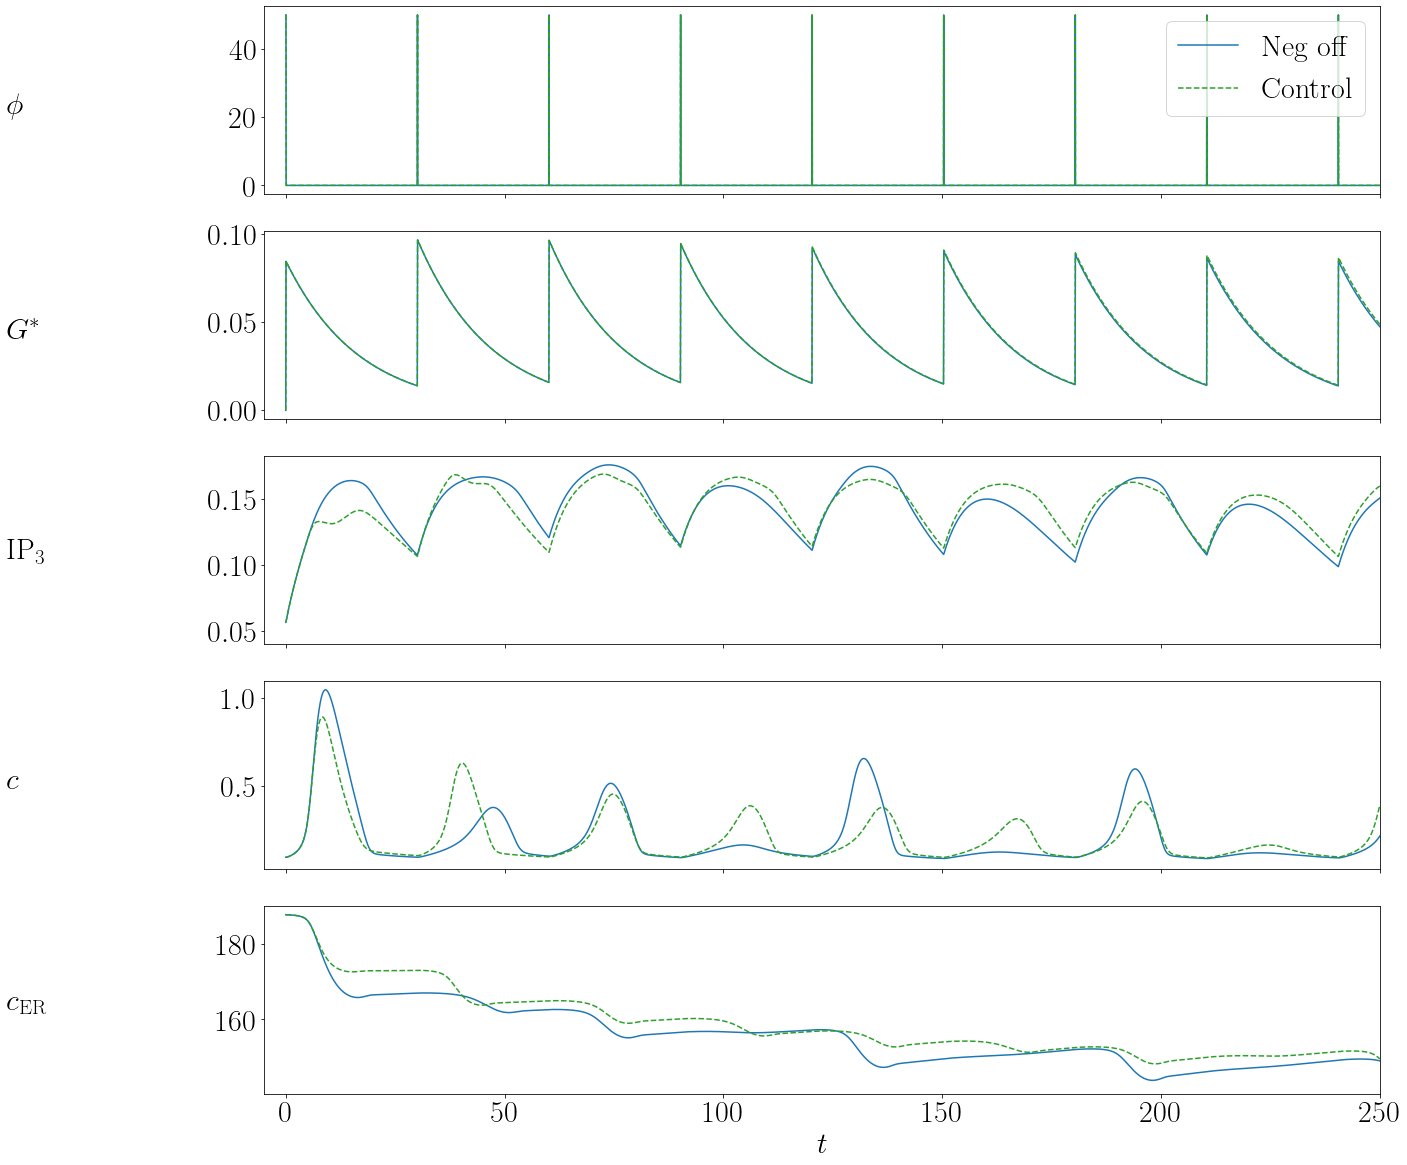

In [11]:
labels = ['glut', 'Gstar', 'p', 'c', 'c_er']
fig, ax = plt.subplots(5, 1, figsize=(20, 20), sharex=True)

load_experiment('50_0.06_30_50_Neg_off')
plot_experiment_plots(labels, axs=ax, legend_label='Neg off', color=color_cycle[0])

# load_experiment('100_0.06_30_50_Gd2_off')
# plot_experiment_plots(labels, axs=ax, legend_label='Gd2 off')

load_experiment('50_0.06_30_50')
plot_experiment_plots(labels, axs=ax, legend_label='Control', color=color_cycle[2], linestyle='--')

ax[0].set_xlim([-5, 250])
ax[0].legend()

Experiment loaded
Experiment loaded


C:\Users\Andy\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


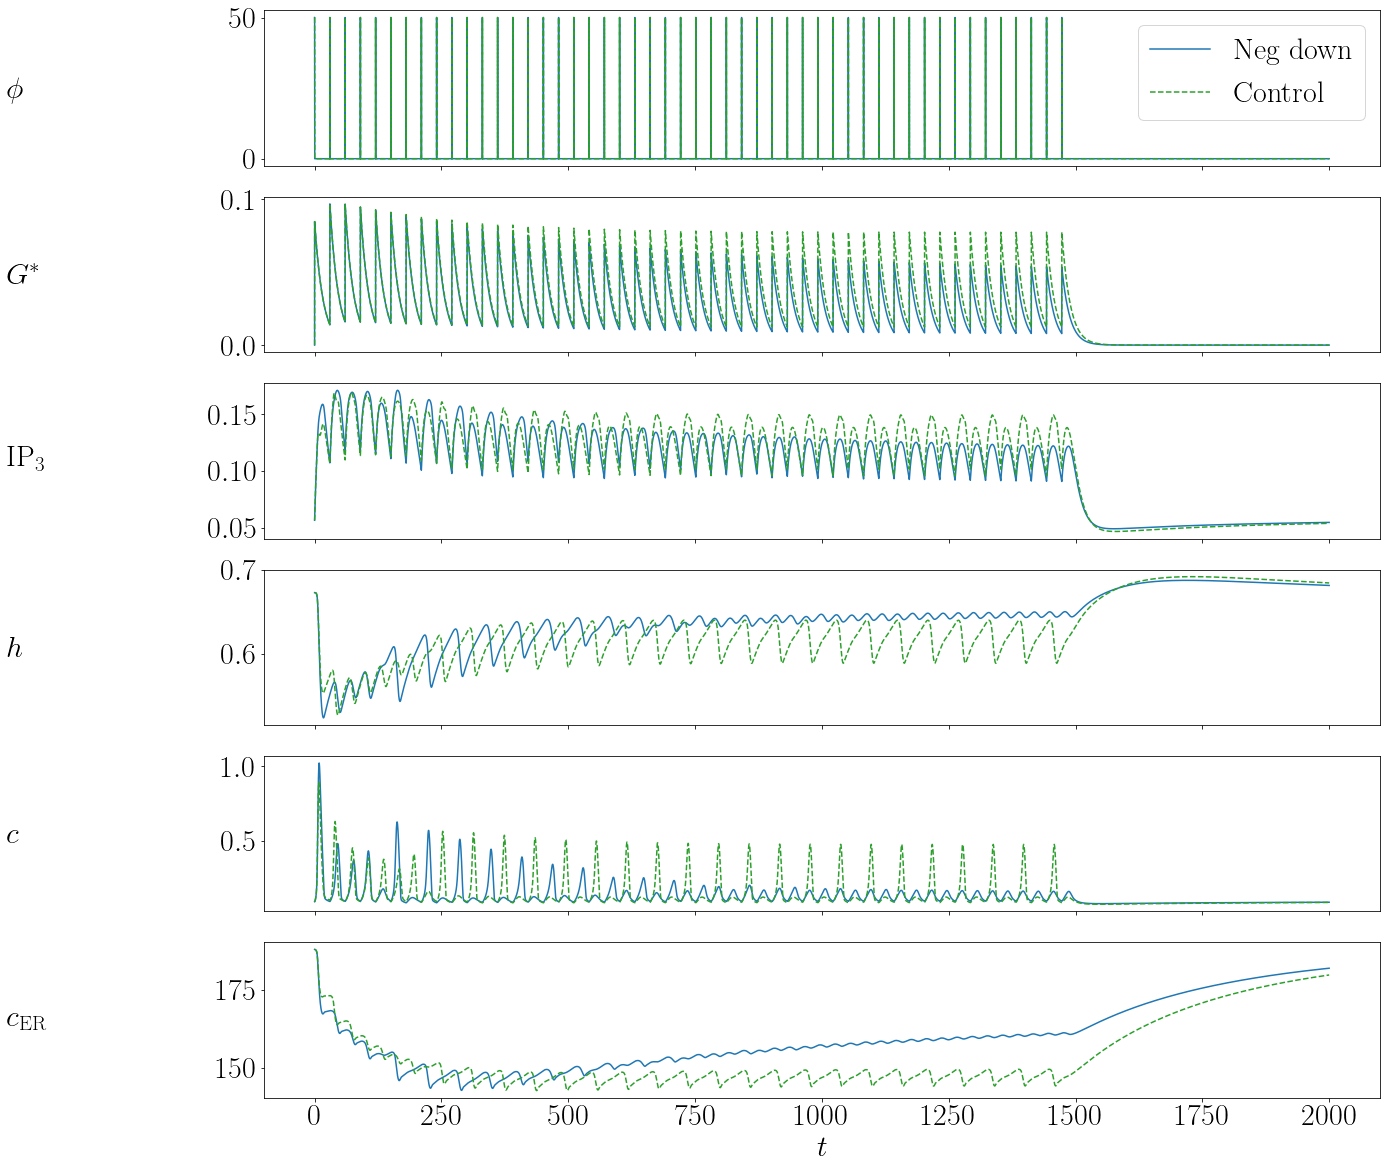

In [15]:
labels = ['glut', 'Gstar', 'p', 'h', 'c', 'c_er']
fig, ax = plt.subplots(6, 1, figsize=(20, 20), sharex=True)

load_experiment('50_0.06_30_50_Neg_down')
plot_experiment_plots(labels, axs=ax, legend_label='Neg down', color=color_cycle[0])

# load_experiment('100_0.06_30_50_Gd2_off')
# plot_experiment_plots(labels, axs=ax, legend_label='Gd2 off')

load_experiment('50_0.06_30_50')
plot_experiment_plots(labels, axs=ax, legend_label='Control', color=color_cycle[2], linestyle='--')

# ax[0].set_xlim([-5, 250])
ax[0].legend()

Experiment loaded
Experiment loaded


C:\Users\Andy\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


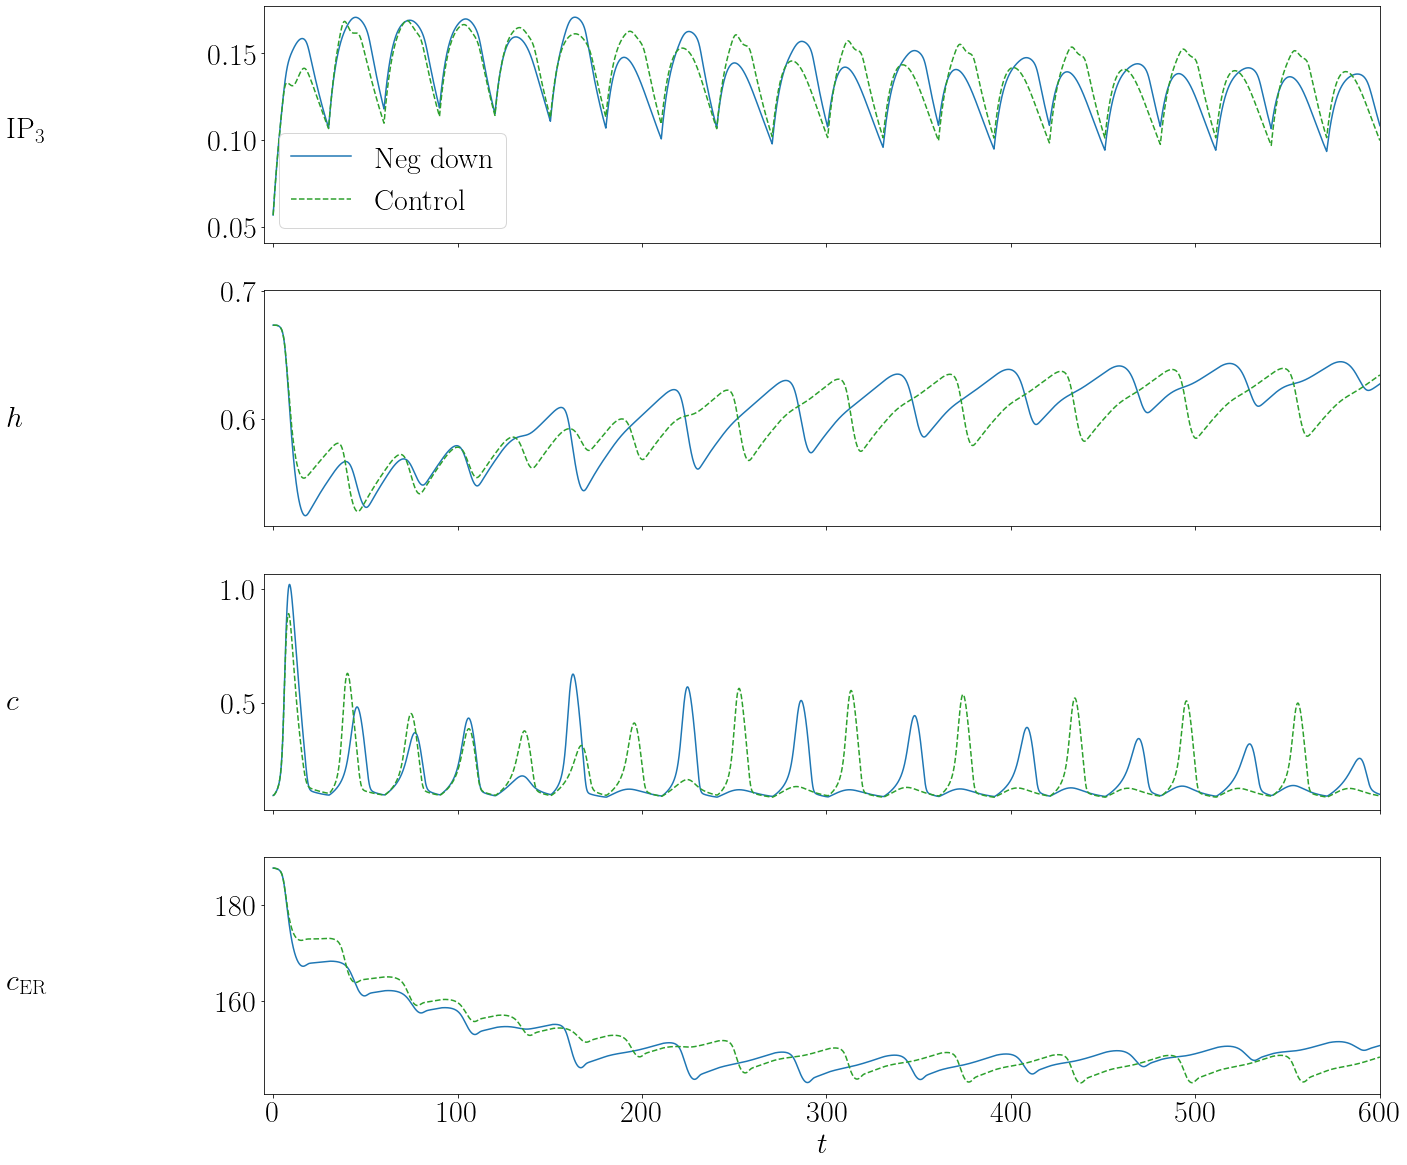

In [19]:
labels = ['p', 'h', 'c', 'c_er']
fig, ax = plt.subplots(4, 1, figsize=(20, 20), sharex=True)

load_experiment('50_0.06_30_50_Neg_down')
plot_experiment_plots(labels, axs=ax, legend_label='Neg down', color=color_cycle[0], plot_input=False)

# load_experiment('100_0.06_30_50_Gd2_off')
# plot_experiment_plots(labels, axs=ax, legend_label='Gd2 off')

load_experiment('50_0.06_30_50')
plot_experiment_plots(labels, axs=ax, legend_label='Control', color=color_cycle[2], linestyle='--',
                     plot_input=False)

ax[0].set_xlim([-5, 600])
ax[0].legend()

In [ ]:
labels = ['p', 'h', 'c', 'c_er']
fig, ax = plt.subplots(4, 1, figsize=(20, 20), sharex=True)

load_experiment('50_0.06_30_50_Neg_down_1.1')
plot_experiment_plots(labels, axs=ax, legend_label='Neg down', color=color_cycle[0], plot_input=False)

# load_experiment('100_0.06_30_50_Gd2_off')
# plot_experiment_plots(labels, axs=ax, legend_label='Gd2 off')

load_experiment('50_0.06_30_50')
plot_experiment_plots(labels, axs=ax, legend_label='Control', color=color_cycle[2], linestyle='--',
                     plot_input=False)

# ax[0].set_xlim([-5, 600])
ax[0].legend()

Experiment loaded
Experiment loaded
Experiment loaded


C:\Users\Andy\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


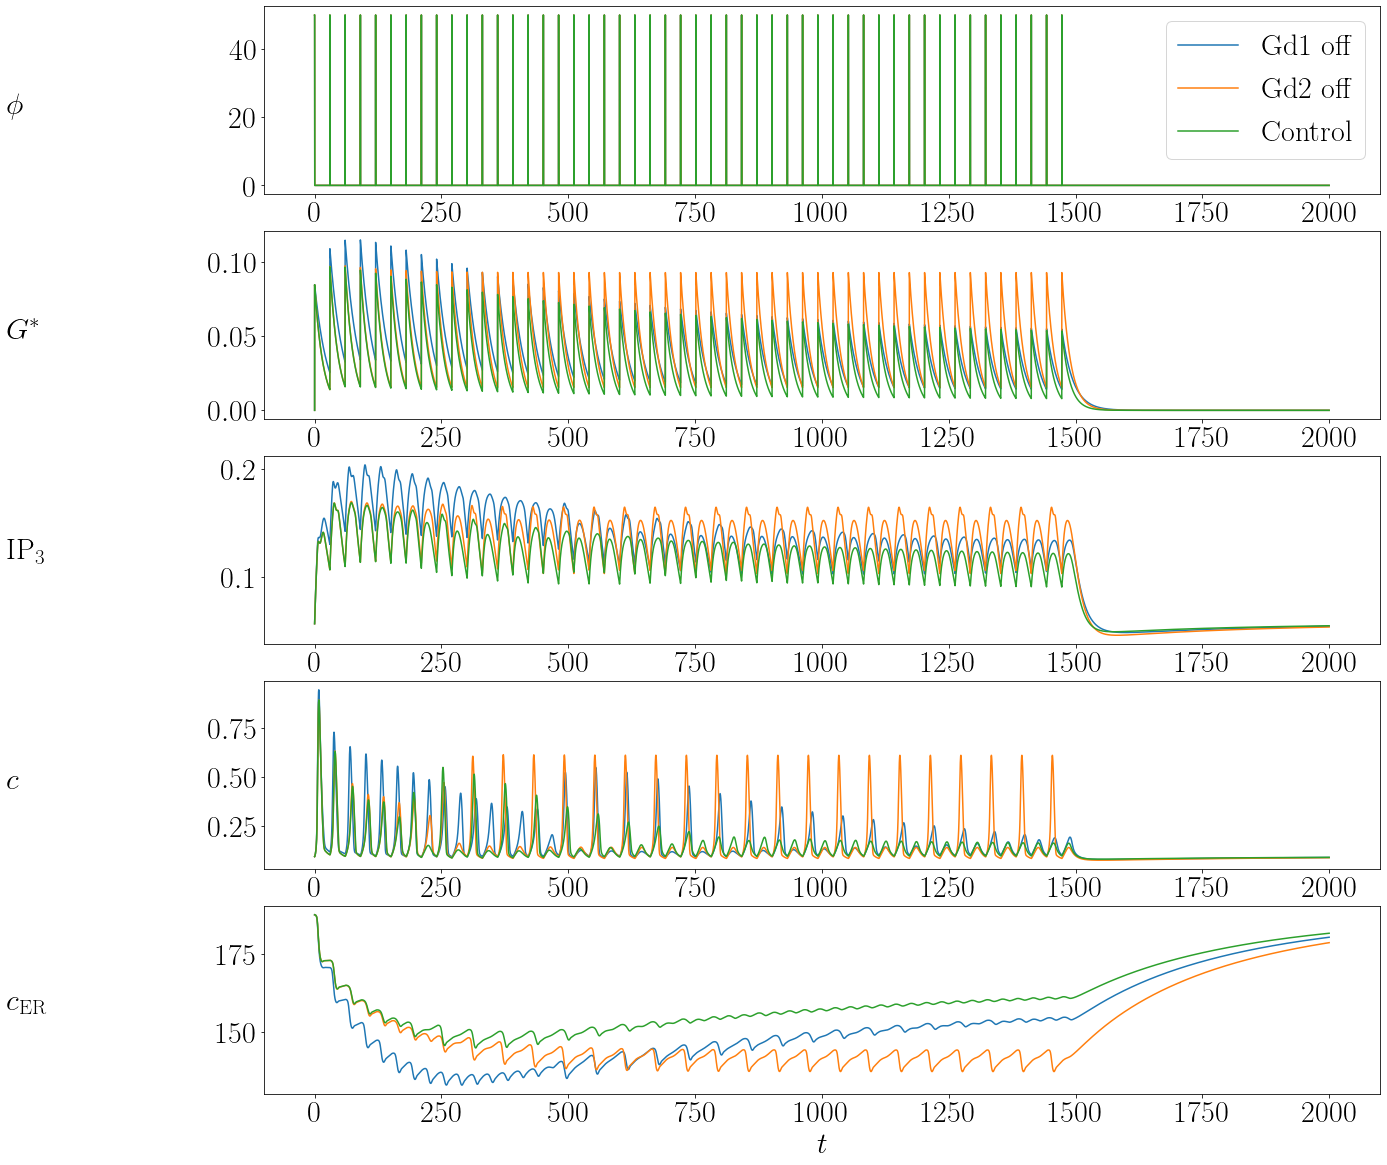

In [21]:
labels = ['glut', 'Gstar', 'p', 'c', 'c_er']
fig, ax = plt.subplots(5, 1, figsize=(20, 20))

load_experiment('50_0.06_30_50_Gd1_off')
plot_experiment_plots(labels, axs=ax, legend_label='Gd1 off')

load_experiment('50_0.06_30_50_Gd2_off')
plot_experiment_plots(labels, axs=ax, legend_label='Gd2 off')

load_experiment('50_0.06_30_50')
plot_experiment_plots(labels, axs=ax, legend_label='Control')


ax[0].legend()

# Relative peak to spritz frequency

Here we are trying to determine how often calcium produces a spike in response to the glutamate spritz input. We collect data for experiments of 50 spritzes with glutamate strengths of 1, 2, 3,... 100, with 30 seconds between each 0.06 second spritz. We also collect this same data with Gd2 turned off

## Data Collection

Here we run the actual data collection

In [3]:
'''Data Collection'''

input_maxes = np.arange(99, 100)


cfg.t_f = 2000
cfg.input_duration = 2000
cfg.kd2 = 0

for input_max in tqdm(input_maxes):
    # fig, ax = plt.subplots(4, 2, figsize=(20, 10), sharey='row')

    cfg.input_max = input_max
    cfg.oscillation_on_duration = 0.06
    cfg.oscillation_off_duration = 30
    cfg.num_oscillations = 50

    run_experiment('oscillation', t_f=cfg.t_f, max_step=0.005)
    save_experiment(str(input_max) + '_0.06_30_50_Gd2_off')

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:23<00:00, 143.48s/it]

Experiment saved


## How to determine peaks

To determine where peaks occur, instead of looking at calcium and trying to determine what classifies as a spike response, we look at c$_{ER}$ dynamics. When a calcium does not have a sufficiently strong peak, the derivative of c$_{ER}$ in time is not negative (which is determined numerically by seeing that it does not reach a trough). 

We use this to calculate "effective calcium interspike intervals"

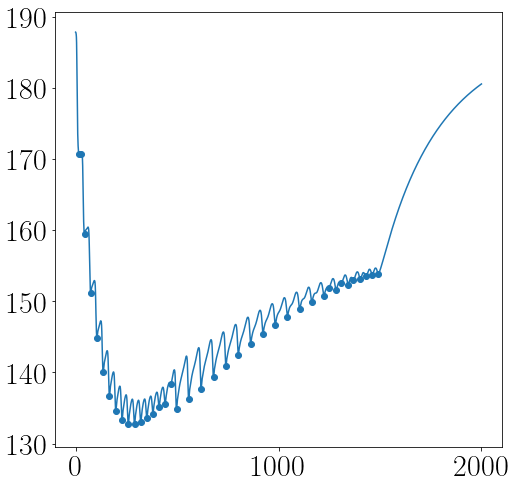

In [50]:
peaks = scipy.signal.find_peaks(-cfg.c_er)[0]
plt.figure(figsize=(8, 8))
plt.plot(cfg.t, cfg.c_er)
plt.scatter(cfg.t[peaks], cfg.c_er[peaks])

### Showing how this peak detection works with previous experiment results

Demonstrating how this peak detection works with 50 and 100 $\mu$M spritzes with Gd1 and Gd2 off. Note that spritzes occur every 30 seconds

There is a slight transient behavior region at the start where calcium responds pretty much every time there is a glutamte spritz. Afterwards, it transitions to responding every other spritz (shown by 60 second interspike intervals). If we were to run it for longer, the 50 $\mu$M spritzes with Gd1 off would converge to the 30 seconds ISI line

Text(0, 0.5, 'c$_{ER}$ inter-trough intervals')

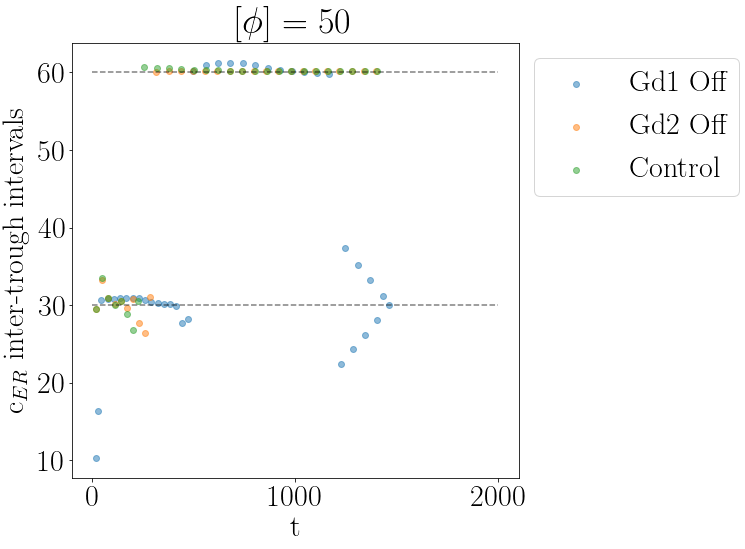

In [68]:
plt.figure(figsize=(8, 8))

load_experiment('50_0.06_30_50_Gd1_off', verbose=False)
troughs = scipy.signal.find_peaks(-cfg.c_er)[0]
plt.scatter(cfg.t[troughs[:-1]], np.diff(cfg.t[troughs]), label='Gd1 Off', alpha=0.5)

load_experiment('50_0.06_30_50_Gd2_off', verbose=False)
troughs = scipy.signal.find_peaks(-cfg.c_er)[0]
plt.scatter(cfg.t[troughs[:-1]], np.diff(cfg.t[troughs]), alpha=0.5, label='Gd2 Off')

load_experiment('50_0.06_30_50', verbose=False)
troughs = scipy.signal.find_peaks(-cfg.c_er)[0]
plt.scatter(cfg.t[troughs[:-1]], np.diff(cfg.t[troughs]), alpha=0.5, label='Control')

plt.plot([cfg.t[0], cfg.t[-1]], [30, 30], linestyle='--', color='k', alpha=0.5)
plt.plot([cfg.t[0], cfg.t[-1]], [60, 60], linestyle='--', color='k', alpha=0.5)
plt.legend(bbox_to_anchor=(1, 1, 0, 0), loc='upper left')
plt.title('[$\phi$] $=50$')
plt.xlabel('t')
plt.ylabel('c$_{ER}$ inter-trough intervals')

# spritzes = np.arange(0, 1530, 30.06)
# plt.scatter(spritzes, np.full(len(spritzes), 0), marker='x', alpha=0.5, label='Spritz')

Text(0, 0.5, 'c$_{ER}$ inter-trough intervals')

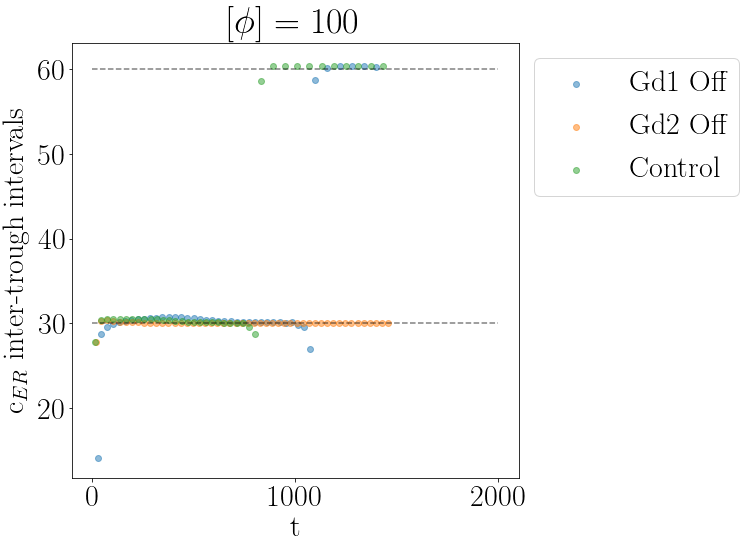

In [67]:
plt.figure(figsize=(8, 8))

load_experiment('100_0.06_30_50_Gd1_off', verbose=False)
troughs = scipy.signal.find_peaks(-cfg.c_er)[0]
plt.scatter(cfg.t[troughs[:-1]], np.diff(cfg.t[troughs]), label='Gd1 Off', alpha=0.5)

load_experiment('100_0.06_30_50_Gd2_off', verbose=False)
troughs = scipy.signal.find_peaks(-cfg.c_er)[0]
plt.scatter(cfg.t[troughs[:-1]], np.diff(cfg.t[troughs]), alpha=0.5, label='Gd2 Off')

load_experiment('100_0.06_30_50', verbose=False)
troughs = scipy.signal.find_peaks(-cfg.c_er)[0]
plt.scatter(cfg.t[troughs[:-1]], np.diff(cfg.t[troughs]), alpha=0.5, label='Control')

plt.plot([cfg.t[0], cfg.t[-1]], [30, 30], linestyle='--', color='k', alpha=0.5)
plt.plot([cfg.t[0], cfg.t[-1]], [60, 60], linestyle='--', color='k', alpha=0.5)
plt.legend(bbox_to_anchor=(1, 1, 0, 0), loc='upper left')
plt.title('[$\phi$] $=100$')
plt.xlabel('t')
plt.ylabel('c$_{ER}$ inter-trough intervals')

## Summarizing Experiments

Here we simply look at each experiment and find these c$_{ER}$ inter-trough intervals. If they have lengths of 29-31 seconds, we call them "single" responses (responding every spritz). If they have lengths of 59-61 seconds, we call them "double" responses. Otherwise, call them "unclear"

In [32]:
def label_isi(experiment_name):
    load_experiment(experiment_name, verbose=False)
    troughs = scipy.signal.find_peaks(-cfg.c_er)[0]

    
    xs = np.arange(0, 1520, 10)
    x_index = 0
    ys = np.zeros(len(xs))
    
    isis = np.diff(cfg.t[troughs])
    
    for i, trough in enumerate(troughs[1:]):
        bound = np.ceil(cfg.t[trough] / 10) * 10
        val = isis[i]
    #     print(val)
        if(val > 29 and val < 31):
            isi = 1
        elif(val > 59 and val < 61):
            isi = 2
        elif(val > 89 and val < 91):
            isi = 3
        else:
            isi = 0

        while xs[x_index] <= bound:
            ys[x_index] = isi
            x_index += 1
            
    return ys

xs = np.arange(0, 1520, 10)
all_ys = []
for i in tqdm(np.arange(0, 101)):
    experiment_name = str(i) + '_0.06_30_50_Gd2_off'
    ys = label_isi(experiment_name)
    all_ys.append(ys)
    
pickle.dump(all_ys, open('data/experiments/spritz_c_er_troughs_Gd2_off', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:00<00:00,  1.68it/s]


Text(0.5, 1.0, 'Control')

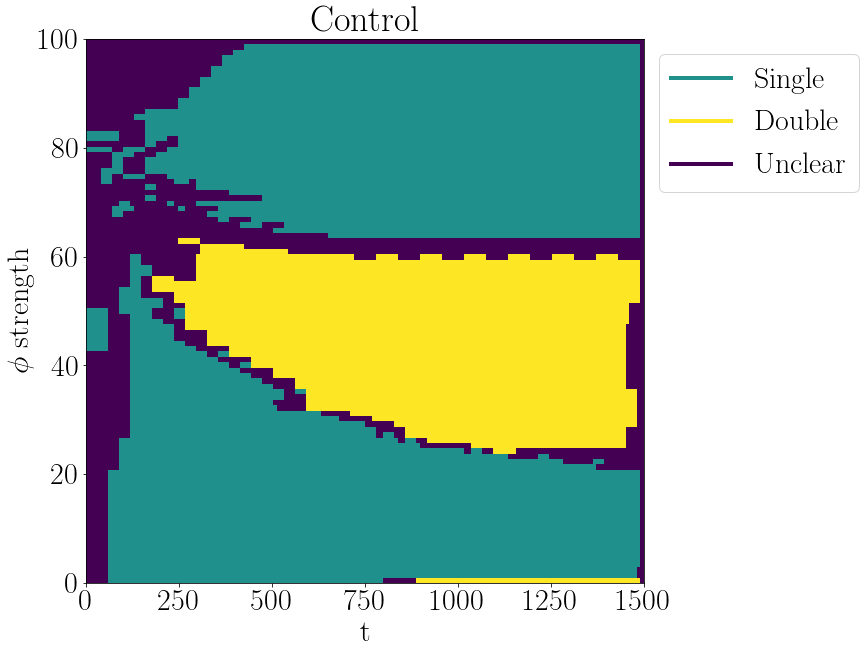

In [69]:
all_ys = pickle.load(open('data/experiments/spritz_c_er_troughs', 'rb'))
Line2D = matplotlib.lines.Line2D

# cmap = plt.get_cmap()
cmap = plt.cm.viridis
legend_colors = [Line2D([0], [0], color=cmap(0.5), lw=4),
                Line2D([0], [0], color=cmap(2.), lw=4),
                Line2D([0], [0], color=cmap(0.), lw=4)]
plt.figure(figsize=(10, 10))
plt.imshow(np.array(all_ys), extent=(0, 1500, 0, 100), aspect='auto')
plt.legend(legend_colors, ['Single', 'Double', 'Unclear'], bbox_to_anchor=(1, 1, 0, 0), loc='upper left')

plt.xlabel('t')
plt.ylabel('$\phi$ strength')
plt.title('Control')

Text(0.5, 1.0, 'Gd2 Off')

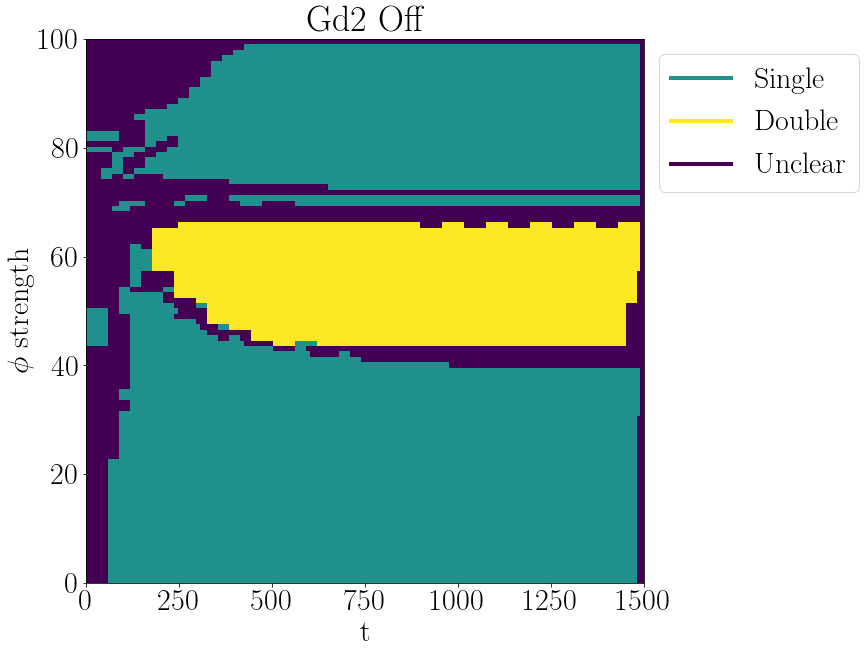

In [70]:
all_ys = pickle.load(open('data/experiments/spritz_c_er_troughs_Gd2_off', 'rb'))
Line2D = matplotlib.lines.Line2D

# cmap = plt.get_cmap()
cmap = plt.cm.viridis
legend_colors = [Line2D([0], [0], color=cmap(0.5), lw=4),
                Line2D([0], [0], color=cmap(2.), lw=4),
                Line2D([0], [0], color=cmap(0.), lw=4)]
plt.figure(figsize=(10, 10))
plt.imshow(np.array(all_ys), extent=(0, 1500, 0, 100), aspect='auto')
plt.legend(legend_colors, ['Single', 'Double', 'Unclear'], bbox_to_anchor=(1, 1, 0, 0), loc='upper left')

plt.xlabel('t')
plt.ylabel('$\phi$ strength')
plt.title('Gd2 Off')

## Looking for nonstandard behavior

In the above experiments, there are a few lines in the Gd2 off plot where the inter-trough intervals are "unclear" the entire time. We plot them to see what is happening.

In [39]:
all_ys = pickle.load(open('data/experiments/spritz_c_er_troughs_Gd2_off', 'rb'))
for i, ys in enumerate(all_ys):
    if (ys == 0).all():
        print(i)

0
28
32
33


Text(0, 0.5, 'c$_{ER}$ inter-trough intervals')

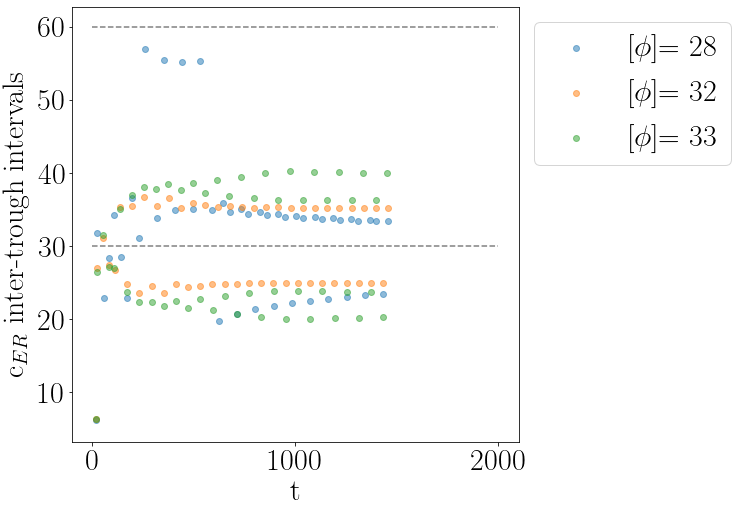

In [75]:
plt.figure(figsize=(8, 8))

load_experiment('28_0.06_30_50_Gd2_off', verbose=False)
troughs = scipy.signal.find_peaks(-cfg.c_er)[0]
plt.scatter(cfg.t[troughs[:-1]], np.diff(cfg.t[troughs]), label='[$\phi$]$=28$', alpha=0.5)

load_experiment('32_0.06_30_50_Gd2_off', verbose=False)
troughs = scipy.signal.find_peaks(-cfg.c_er)[0]
plt.scatter(cfg.t[troughs[:-1]], np.diff(cfg.t[troughs]), label='[$\phi$]$=32$', alpha=0.5)

load_experiment('33_0.06_30_50_Gd2_off', verbose=False)
troughs = scipy.signal.find_peaks(-cfg.c_er)[0]
plt.scatter(cfg.t[troughs[:-1]], np.diff(cfg.t[troughs]), label='[$\phi$]$=33$', alpha=0.5)


plt.plot([cfg.t[0], cfg.t[-1]], [30, 30], linestyle='--', color='k', alpha=0.5)
plt.plot([cfg.t[0], cfg.t[-1]], [60, 60], linestyle='--', color='k', alpha=0.5)
plt.legend(bbox_to_anchor=(1, 1, 0, 0), loc='upper left')
# plt.title('[$\phi$] $=50$')
plt.xlabel('t')
plt.ylabel('c$_{ER}$ inter-trough intervals')

# spritzes = np.arange(0, 1530, 30.06)
# plt.scatter(spritzes, np.full(len(spritzes), 0), marker='x', alpha=0.5, label='Spritz')

Experiment loaded


Text(0.5, 1.0, '[$\\phi$]$=28$')

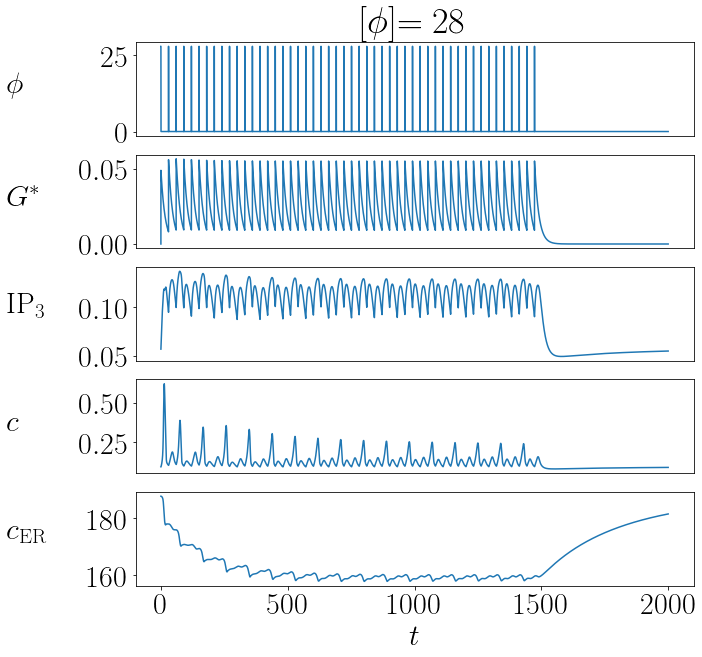

In [79]:
labels = ['glut', 'Gstar', 'p', 'c', 'c_er']
fig, ax = plt.subplots(5, 1, figsize=(10, 10))

# load_experiment('100_0.06_30_50')
# plot_experiment_plots(labels, axs=ax, legend_label='Control')

load_experiment('28_0.06_30_50_Gd2_off')
plot_experiment_plots(labels, axs=ax, remove_xticks=True)
ax[0].set_title('[$\phi$]$=28$')

Experiment loaded


Text(0.5, 1.0, '[$\\phi$]$=32$')

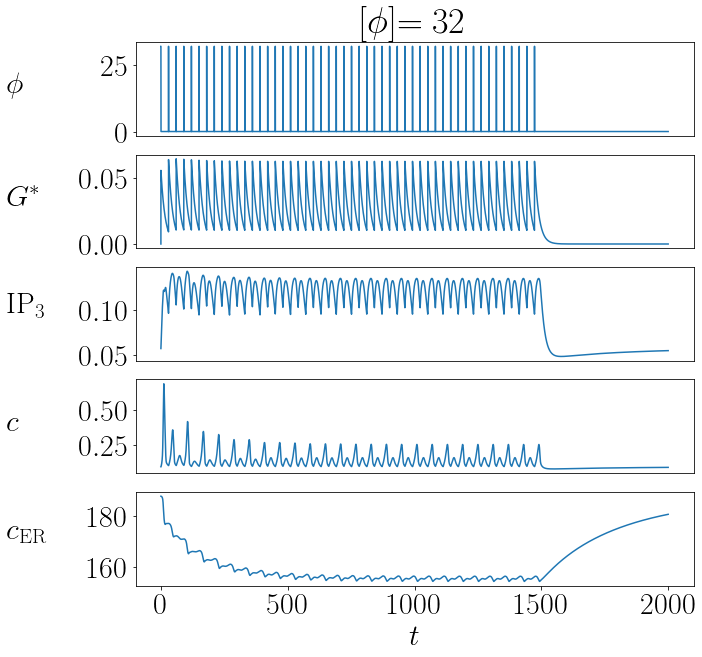

In [80]:
labels = ['glut', 'Gstar', 'p', 'c', 'c_er']
fig, ax = plt.subplots(5, 1, figsize=(10, 10))

# load_experiment('100_0.06_30_50')
# plot_experiment_plots(labels, axs=ax, legend_label='Control')

load_experiment('32_0.06_30_50_Gd2_off')
plot_experiment_plots(labels, axs=ax, remove_xticks=True)
ax[0].set_title('[$\phi$]$=32$')

Experiment loaded


Text(0.5, 1.0, '[$\\phi$]$=33$')

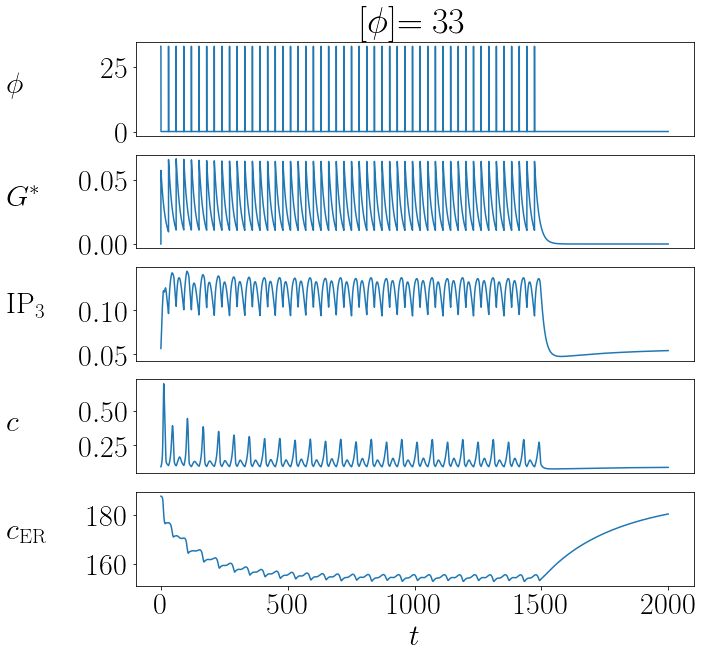

In [81]:
labels = ['glut', 'Gstar', 'p', 'c', 'c_er']
fig, ax = plt.subplots(5, 1, figsize=(10, 10))

# load_experiment('100_0.06_30_50')
# plot_experiment_plots(labels, axs=ax, legend_label='Control')

load_experiment('33_0.06_30_50_Gd2_off')
plot_experiment_plots(labels, axs=ax, remove_xticks=True)
ax[0].set_title('[$\phi$]$=33$')

# Adding Noise

The results of the Marsa's experiment looked a little more stochastic than ours, so I introduced some random noise. Each spritz here has a set base level (e.g. 50 $\mu$M) and then is multiplied by Gaussian noise centered at 1 with standard deviation of 0.05.

This produces some regions where calcium seems to respond every other peak or every three peaks, and looks somewhat realistic to experimental data

Experiment loaded


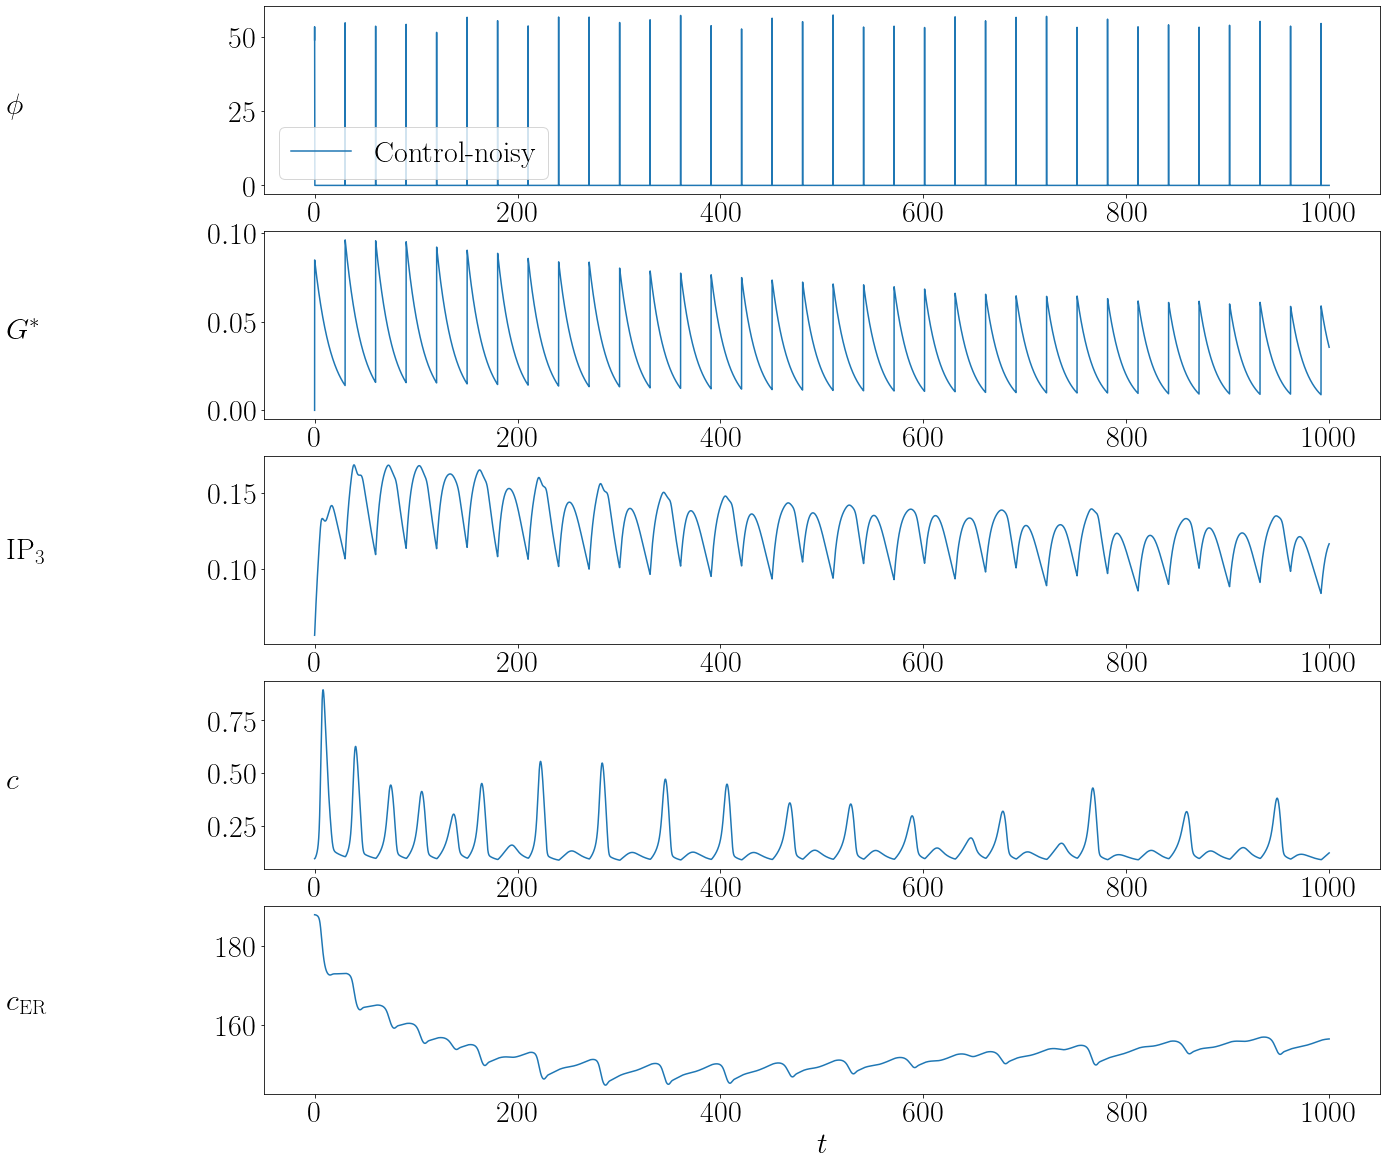

In [5]:
labels = ['glut', 'Gstar', 'p', 'c', 'c_er']
fig, ax = plt.subplots(5, 1, figsize=(20, 20))

# load_experiment('100_0.06_30_50')
# plot_experiment_plots(labels, axs=ax, legend_label='Control')

load_experiment('50_0.06_30_25_noisy')
plot_experiment_plots(labels, axs=ax, legend_label='Control-noisy')

ax[0].legend()